In [ ]:
import pandas as pd
import numpy as np
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

def process_stock_data(file_list):
    """
    Reads CSV files, sets the date index, and calculates return metrics.
    Returns a dictionary of DataFrames keyed by the ticker symbol.
    """
    processed_data = {}

    print(f"Starting data processing for {len(file_list)} files...\n")

    for filepath in file_list:
        try:
            # Load data, parsing dates and setting index simultaneously
            df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')

            # Extract ticker symbol from filename (Format: Category_TICKER_data.csv)
            filename = filepath.split('/')[-1]
            ticker_symbol = filename.split('_')[1]

            # Calculate Simple Daily Returns (% change of Adjusted Close)
            df['Daily Return'] = df['Adj Close'].pct_change()

            # Calculate Log Returns (scaled by 100 for better modeling convergence)
            df['Log Return'] = np.log(df['Close'] / df['Close'].shift(1)) * 100

            # Store processed DataFrame
            processed_data[ticker_symbol] = df
            print(f"[✓] Loaded {ticker_symbol:<5} | Rows: {len(df)}")

        except FileNotFoundError:
            print(f"[!] Critical Error: File not found -> {filepath}")
        except KeyError as e:
            print(f"[!] Data Error: Column {e} missing in {filepath}")
        except Exception as e:
            print(f"[!] Unknown Error processing {filepath}: {str(e)}")

    print("\nProcessing complete. Data stored in 'portfolio_data'.")
    return processed_data

# --- Main Execution ---

target_files = [
    'Banking_SBI_data.csv', 'Banking_HDB_data.csv', 'Banking_KMB_data.csv',
    'Auto_BAJ_data.csv', 'Auto_MSZ_data.csv', 'Banking_ICB_data.csv',
    'Auto_TAM_data.csv', 'Banking_AXB_data.csv', 'Auto_HMC_data.csv',
    'Auto_MAH_data.csv'
]

# Execute processing function
portfolio_data = process_stock_data(target_files)

Starting data processing for 10 files...

[✓] Loaded SBI   | Rows: 2792
[✓] Loaded HDB   | Rows: 2792
[✓] Loaded KMB   | Rows: 2792
[✓] Loaded BAJ   | Rows: 2792
[✓] Loaded MSZ   | Rows: 2792
[✓] Loaded ICB   | Rows: 2792
[✓] Loaded TAM   | Rows: 2792
[✓] Loaded AXB   | Rows: 2792
[✓] Loaded HMC   | Rows: 2792
[✓] Loaded MAH   | Rows: 2792

Processing complete. Data stored in 'portfolio_data'.


In [ ]:


def compute_hurst(series, lag_cap=20):
    """
    Estimates Hurst Exponent using Rescaled Range analysis logic on returns.
    """
    # Convert returns to price path via cumulative sum
    price_path = np.cumsum(series.dropna().values)
    N = len(price_path)

    if N < lag_cap + 1:
        return np.nan

    lags = range(2, lag_cap)
    stdevs = []
    valid_lags = []

    for lag in lags:
        # Compute differences over lag interval
        diffs = np.subtract(price_path[lag:], price_path[:-lag])

        # Calculate standard deviation
        std = np.std(diffs)

        if std > 0:
            stdevs.append(std)
            valid_lags.append(lag)

    if len(valid_lags) < 2:
        return np.nan

    try:
        # Regress log(std) vs log(time)
        slope, _ = np.polyfit(np.log(valid_lags), np.log(stdevs), 1)
        return slope
    except:
        return np.nan

# --- Main Step 2 Execution ---

metrics = {}

print("Starting Step 2: Hurst Exponent and Volatility Analysis...\n")

for ticker, df in portfolio_data.items():
    # 1. Compute Hurst Exponents
    hurst_daily = compute_hurst(df['Daily Return'])
    hurst_log = compute_hurst(df['Log Return'])

    # 2. Compute Volatility Metrics
    vol_daily = df['Daily Return'].std()
    vol_monthly = vol_daily * np.sqrt(21)  # Approx 21 trading days/month
    vol_annual = vol_daily * np.sqrt(252)  # Approx 252 trading days/year

    # Store results
    metrics[ticker] = {
        'Hurst (Daily)': hurst_daily,
        'Hurst (Log)': hurst_log,
        'Volatility (Daily)': vol_daily,
        'Volatility (Monthly)': vol_monthly,
        'Volatility (Annual)': vol_annual
    }

print("Calculations complete.")

# Display results
step2_df = pd.DataFrame.from_dict(metrics, orient='index')
step2_df.index.name = 'Ticker'
display(step2_df)

Starting Step 2: Hurst Exponent and Volatility Analysis...

Calculations complete.


,Hurst (Daily),Hurst (Log),Volatility (Daily),Volatility (Monthly),Volatility (Annual)
Ticker,,,,,
SBI,0.521319,0.525154,0.022140,0.101459,0.351463
HDB,0.457463,0.463391,0.015019,0.068827,0.238422
KMB,0.442213,0.447201,0.018330,0.084000,0.290984
BAJ,0.475874,0.477551,0.016603,0.076086,0.263571
MSZ,0.502318,0.507088,0.018660,0.085510,0.296214
ICB,0.464032,0.469431,0.021785,0.099831,0.345823
TAM,0.542471,0.545254,0.026773,0.122688,0.425005
AXB,0.482527,0.490132,0.023150,0.106088,0.367501
HMC,0.464792,0.465852,0.018576,0.085126,0.294886


Starting Step 3: Statistical Plots & Measures...

Generating diagnostics for SBI...


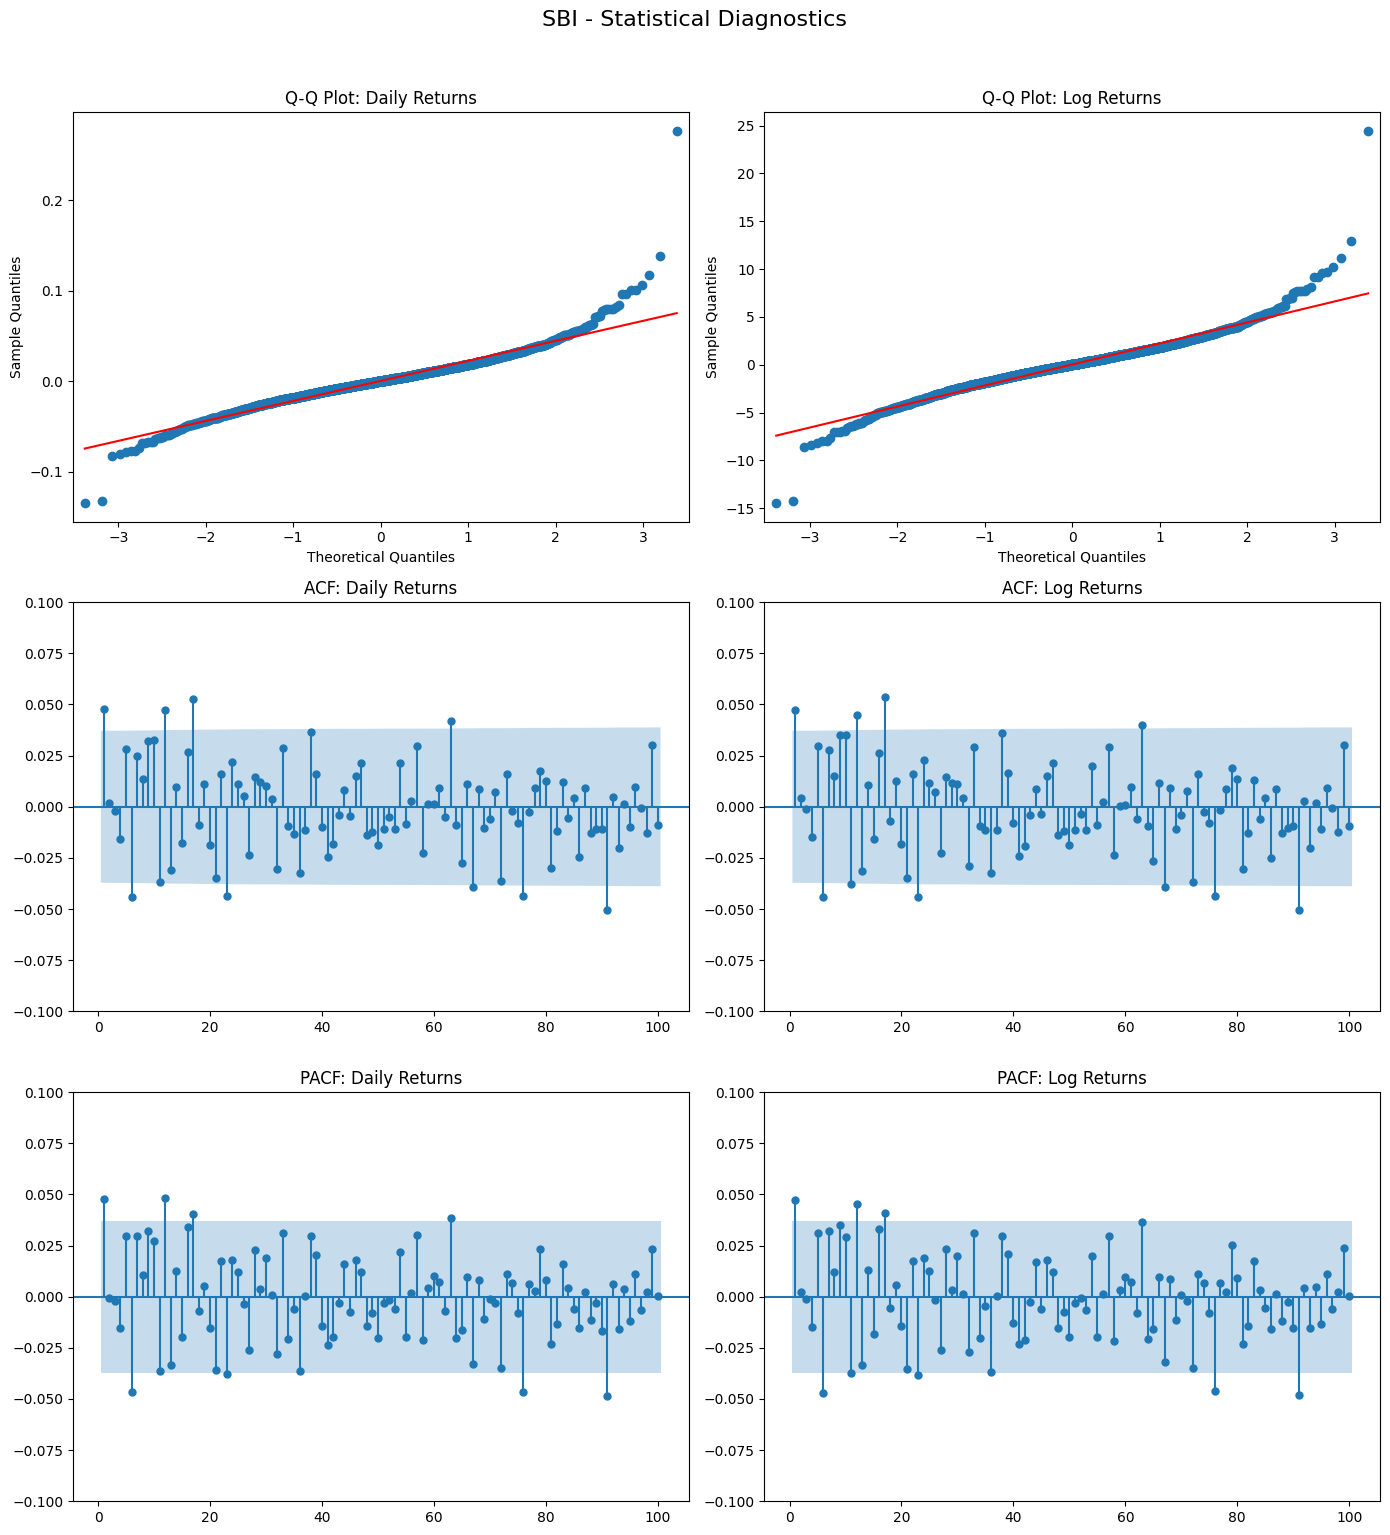

Generating diagnostics for HDB...


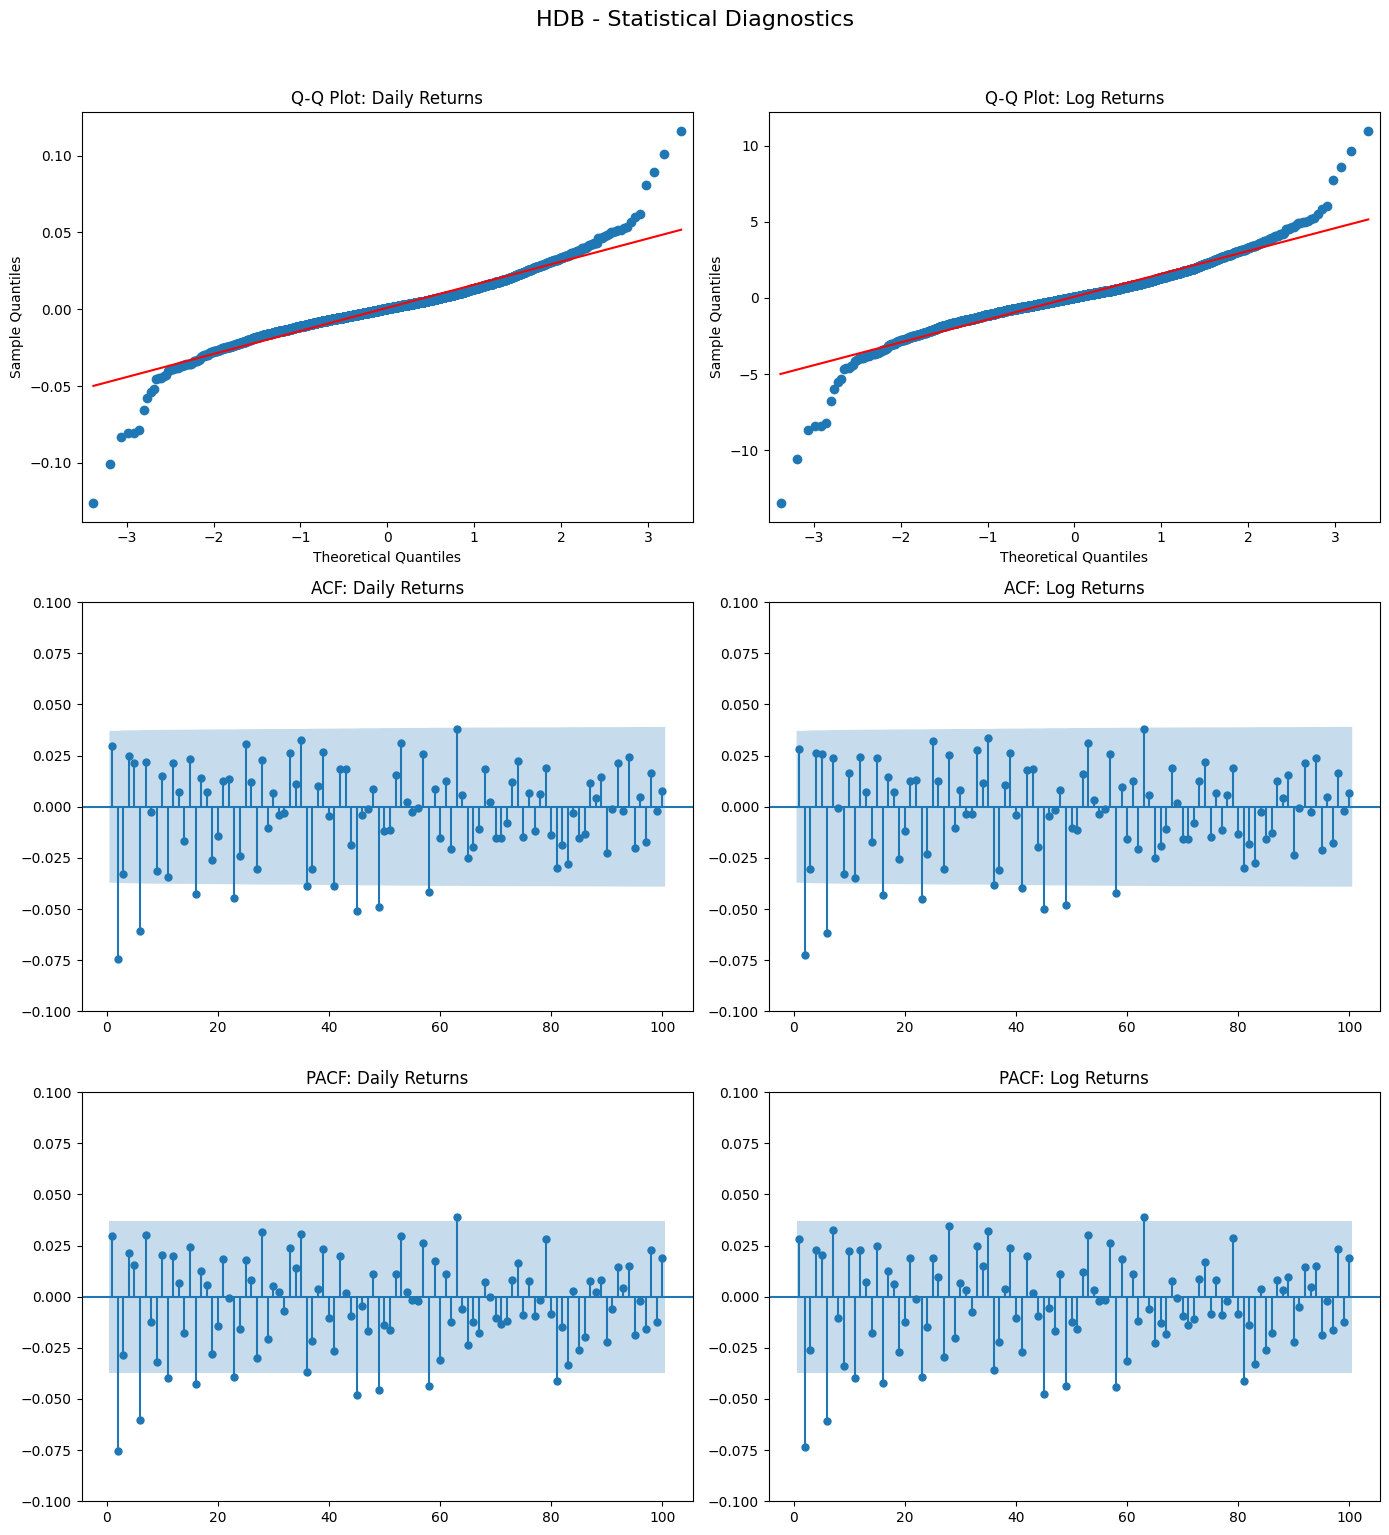

Generating diagnostics for KMB...


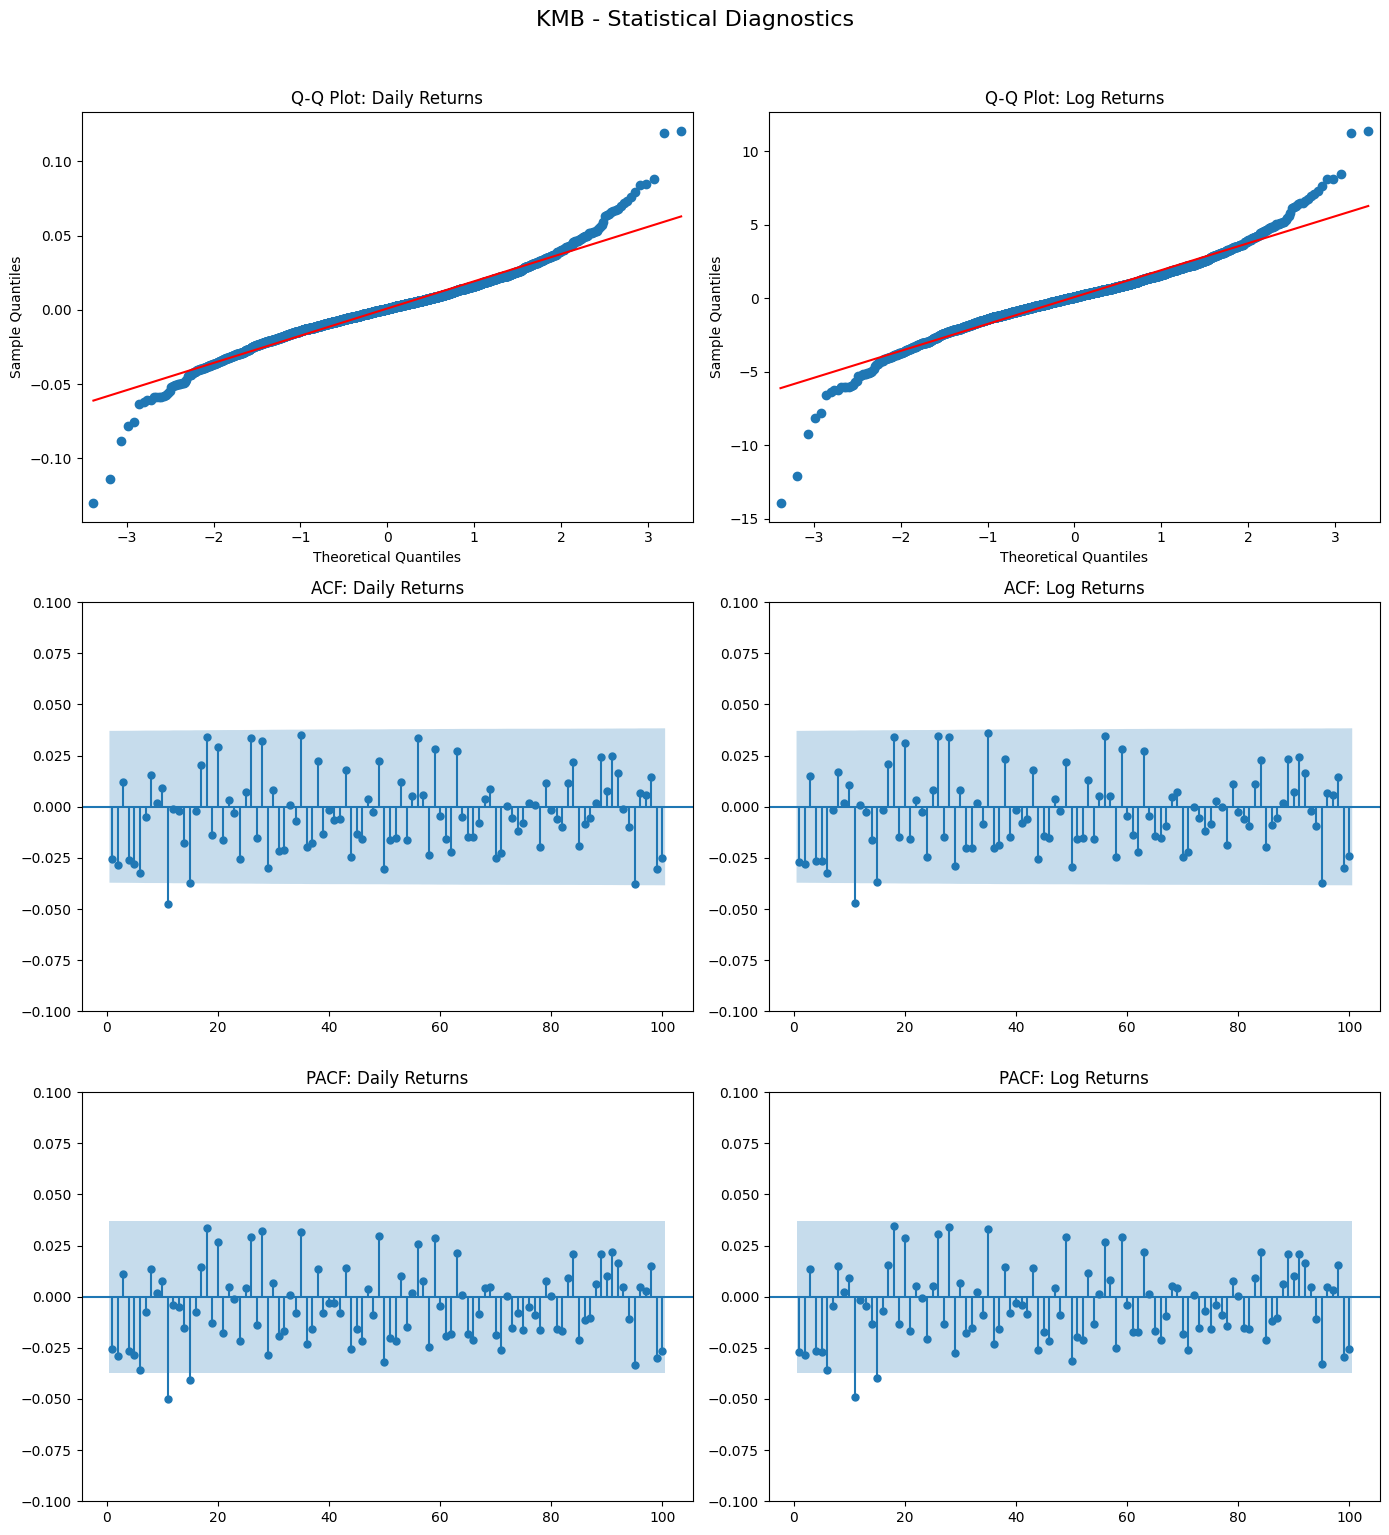

Generating diagnostics for BAJ...


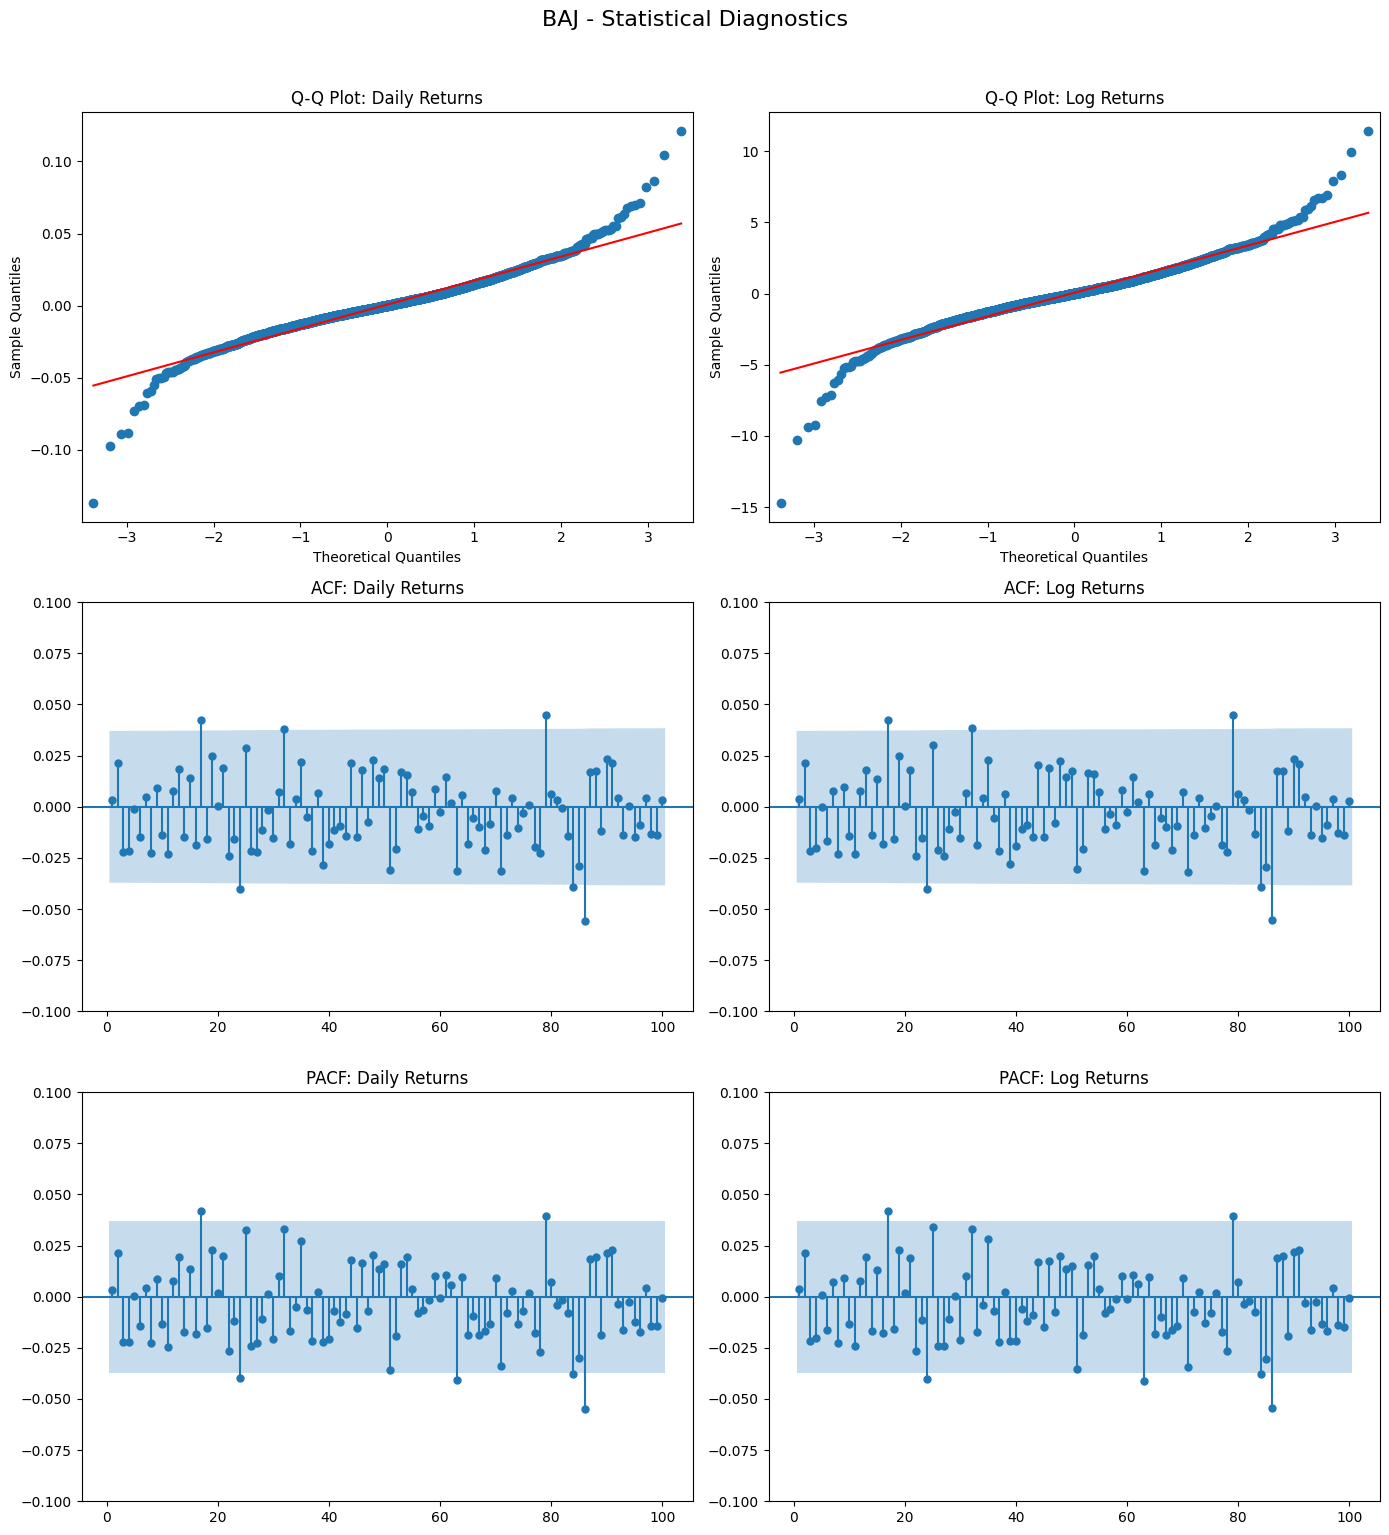

Generating diagnostics for MSZ...


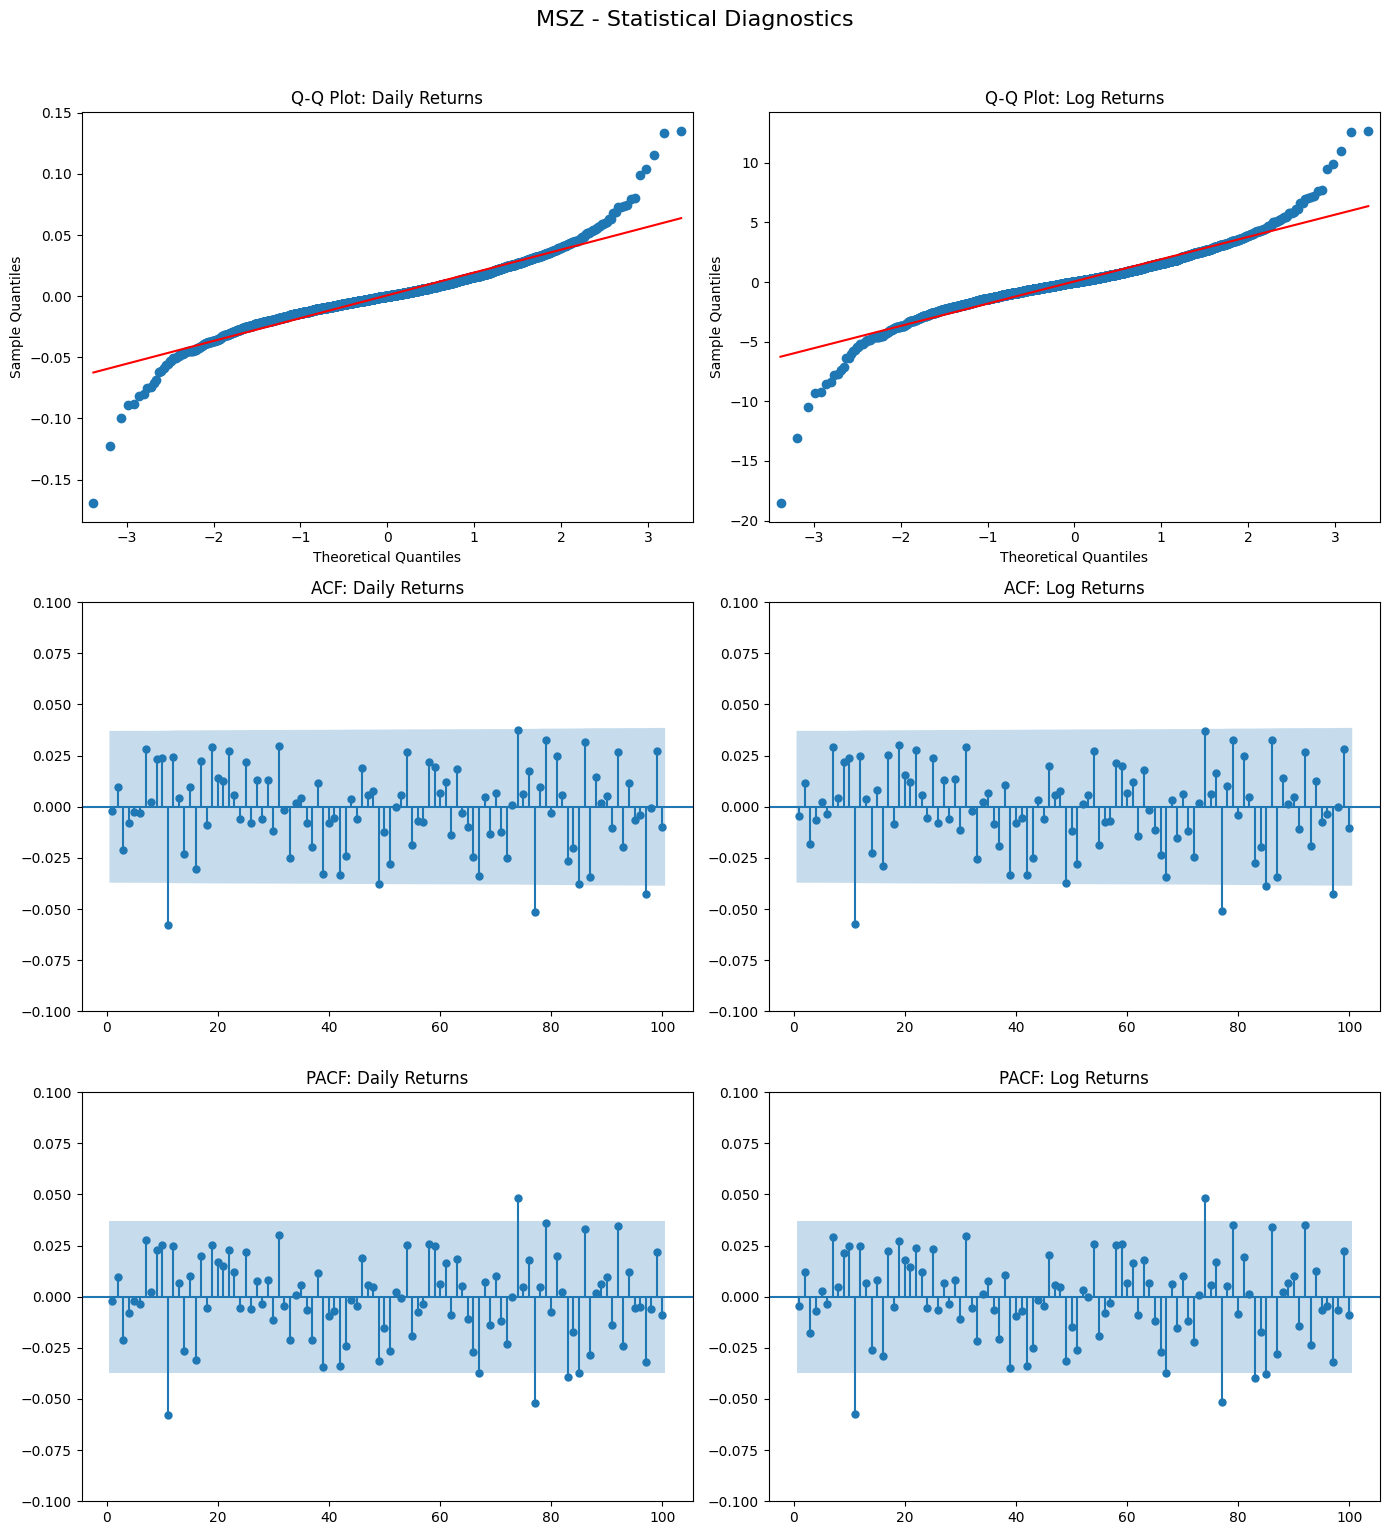

Generating diagnostics for ICB...


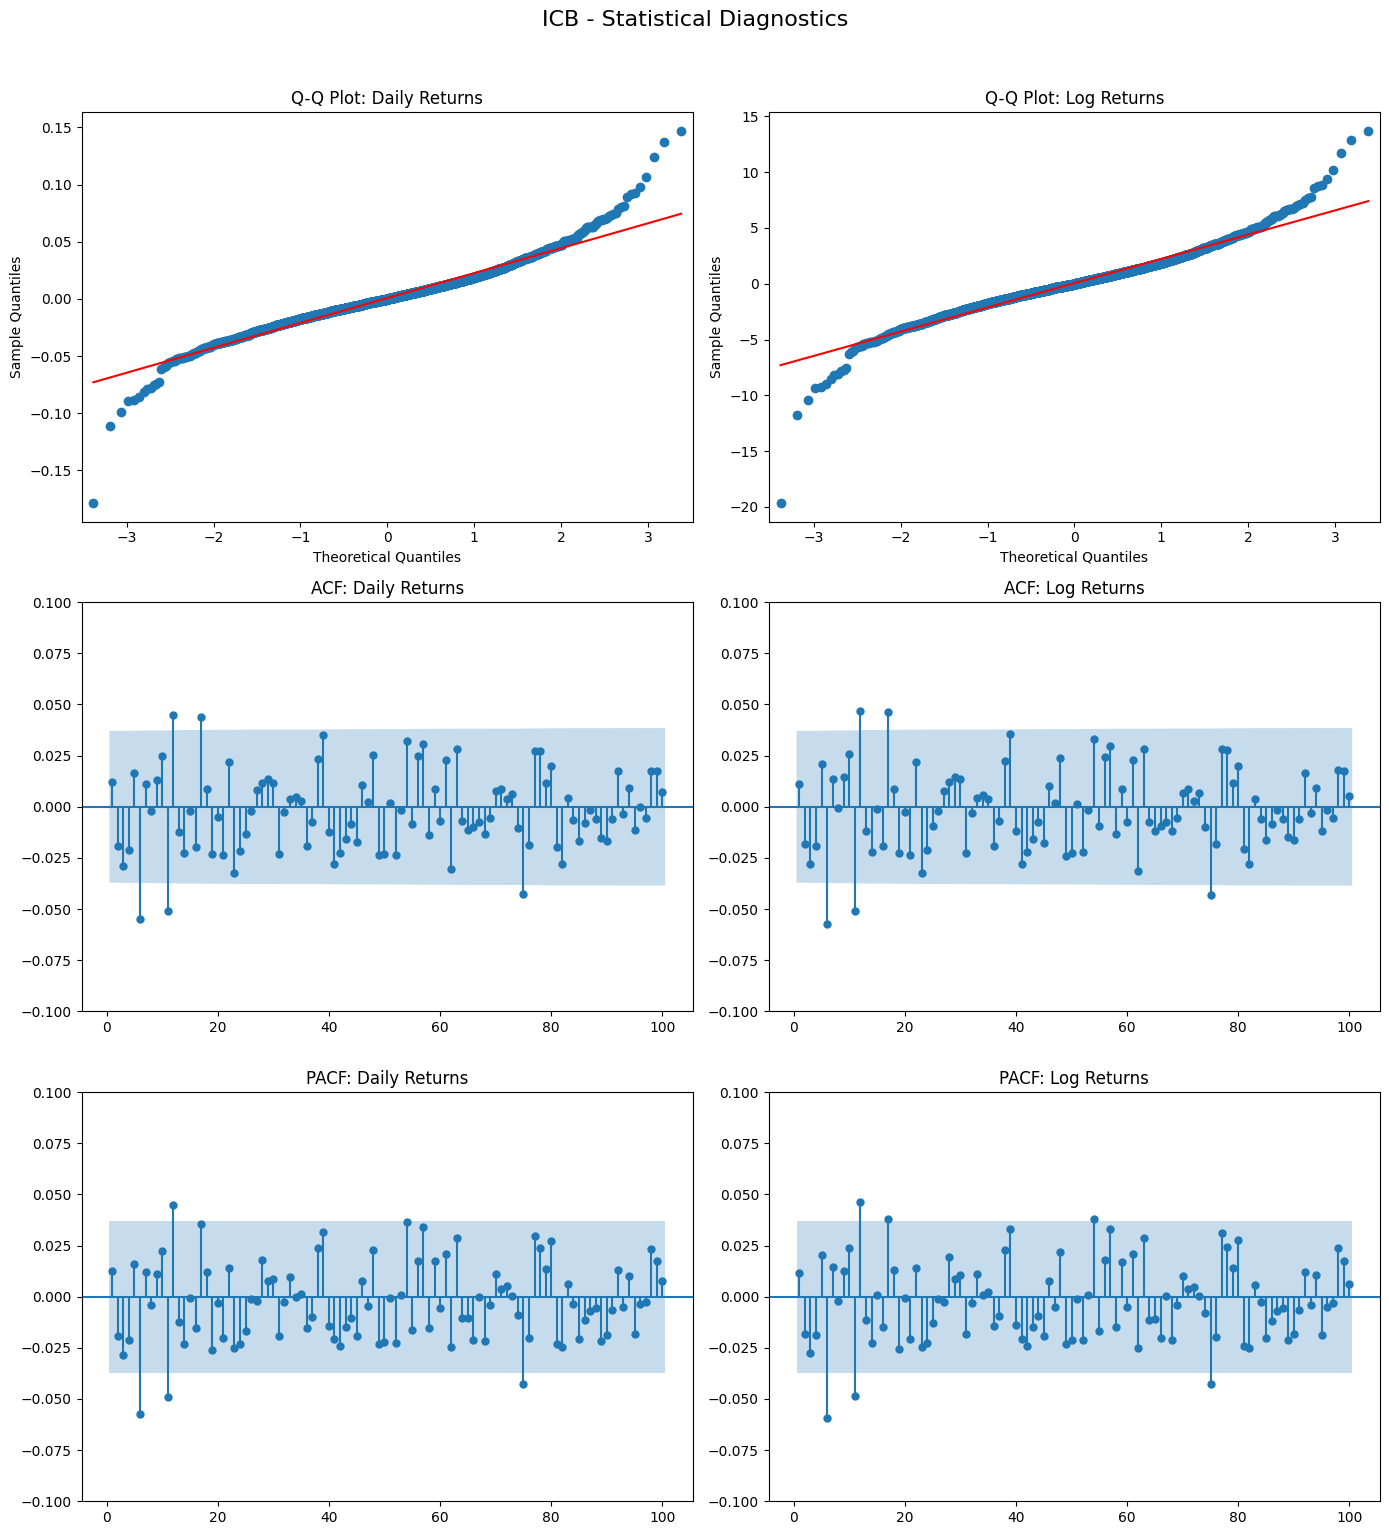

Generating diagnostics for TAM...


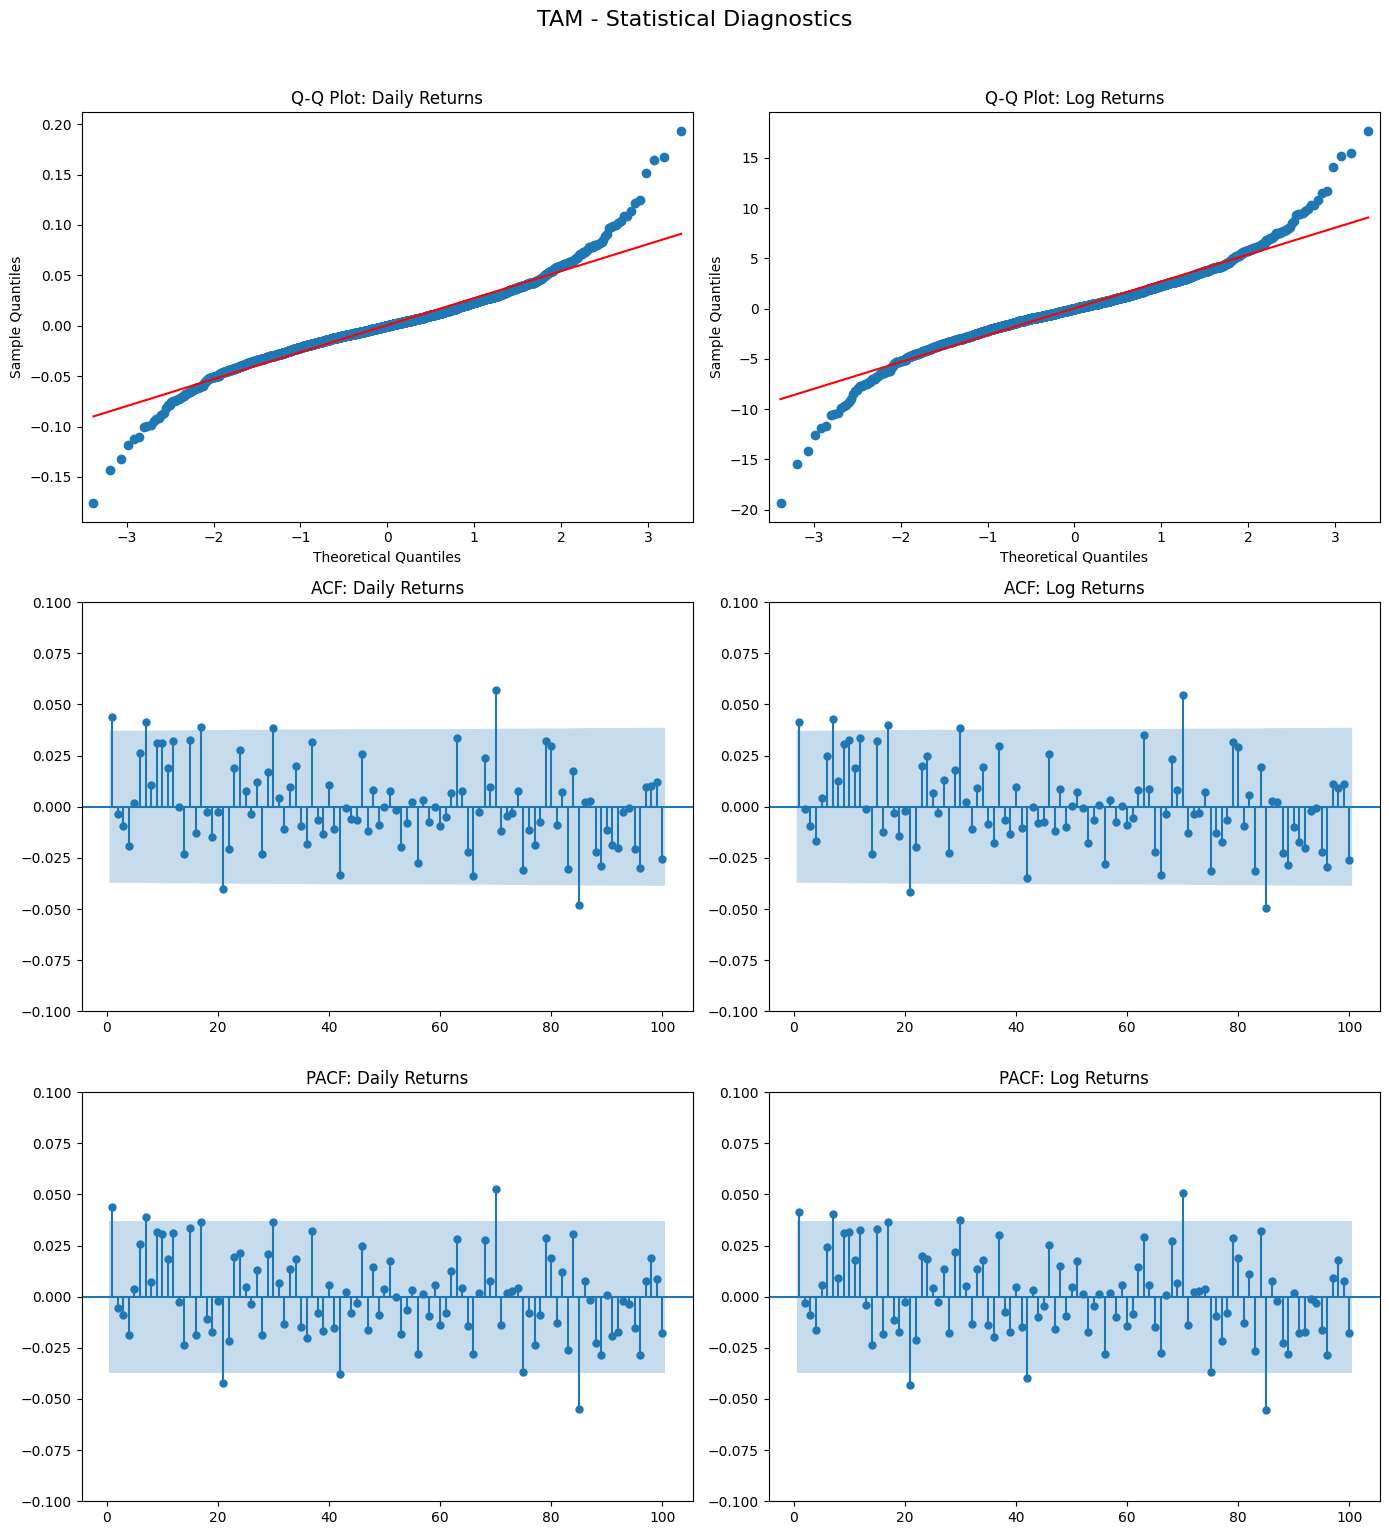

Generating diagnostics for AXB...


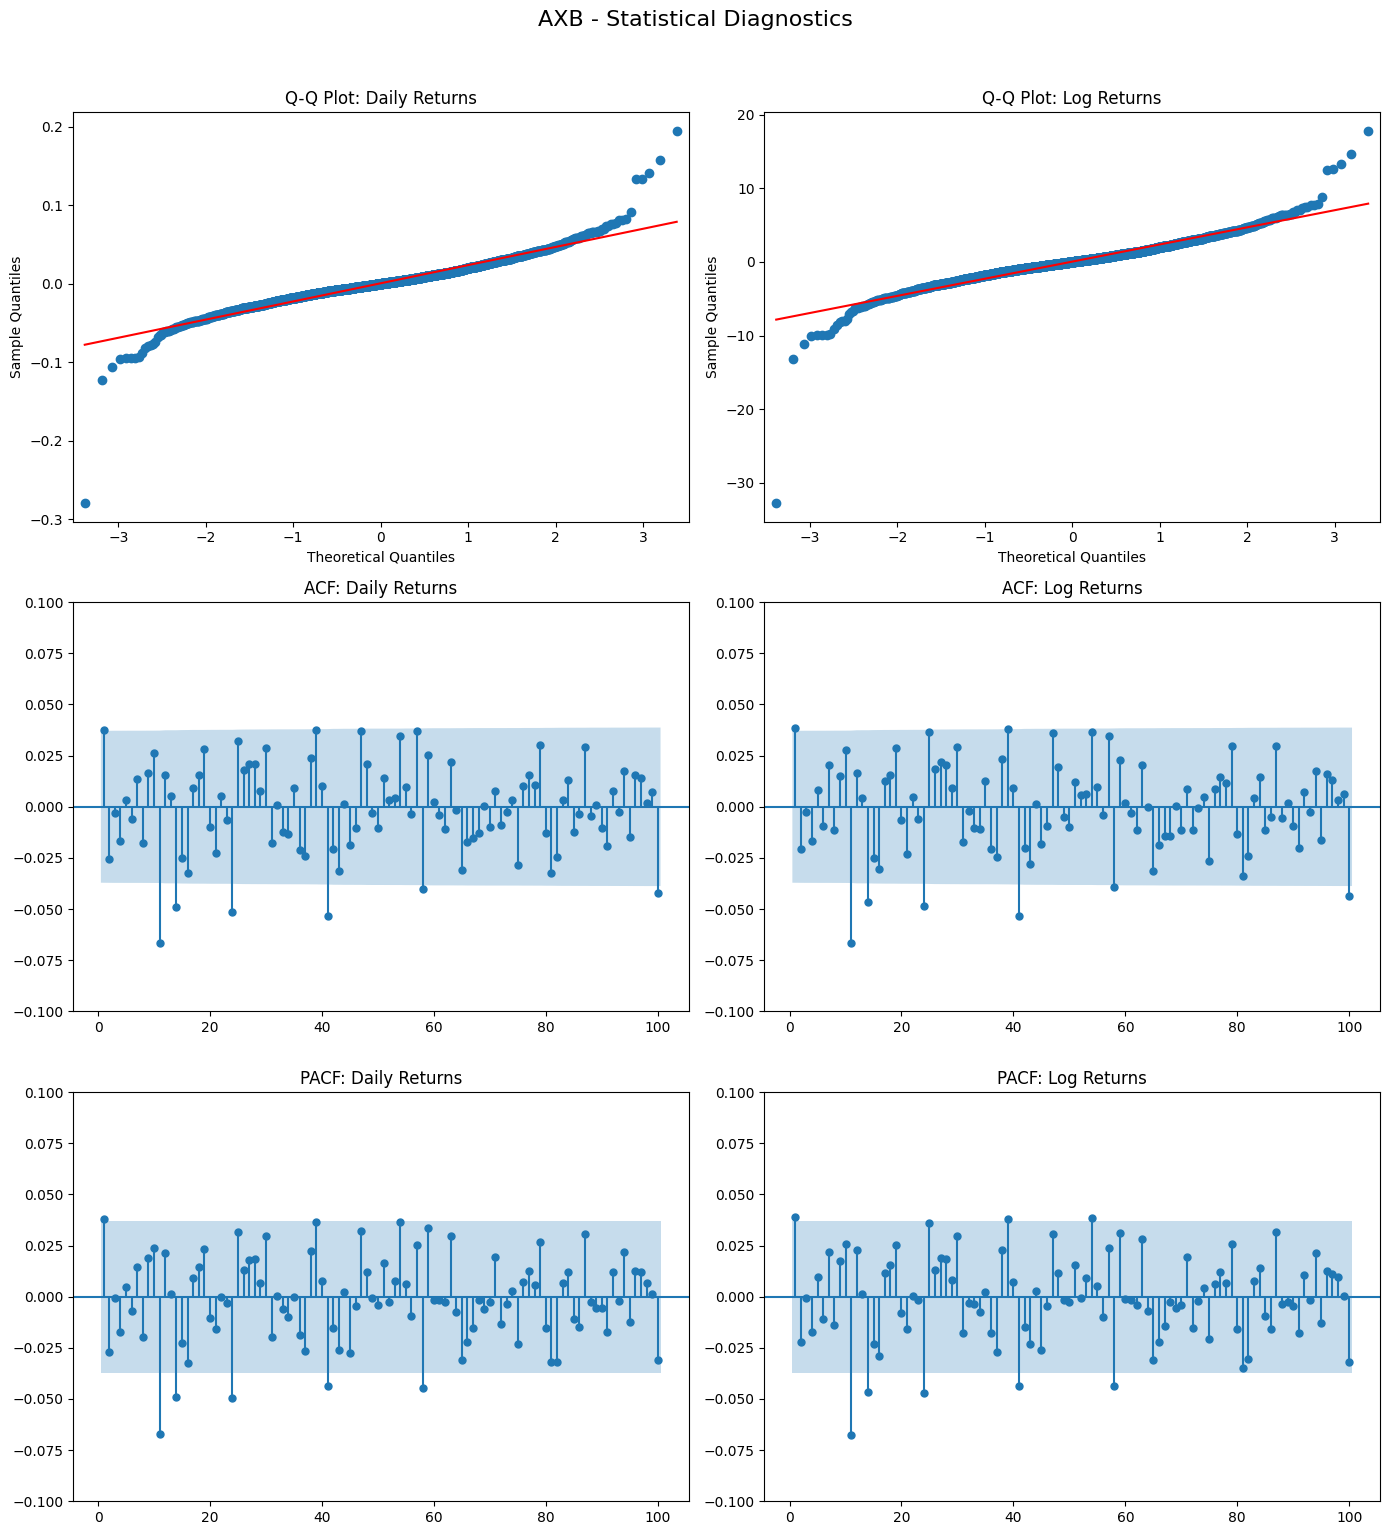

Generating diagnostics for HMC...


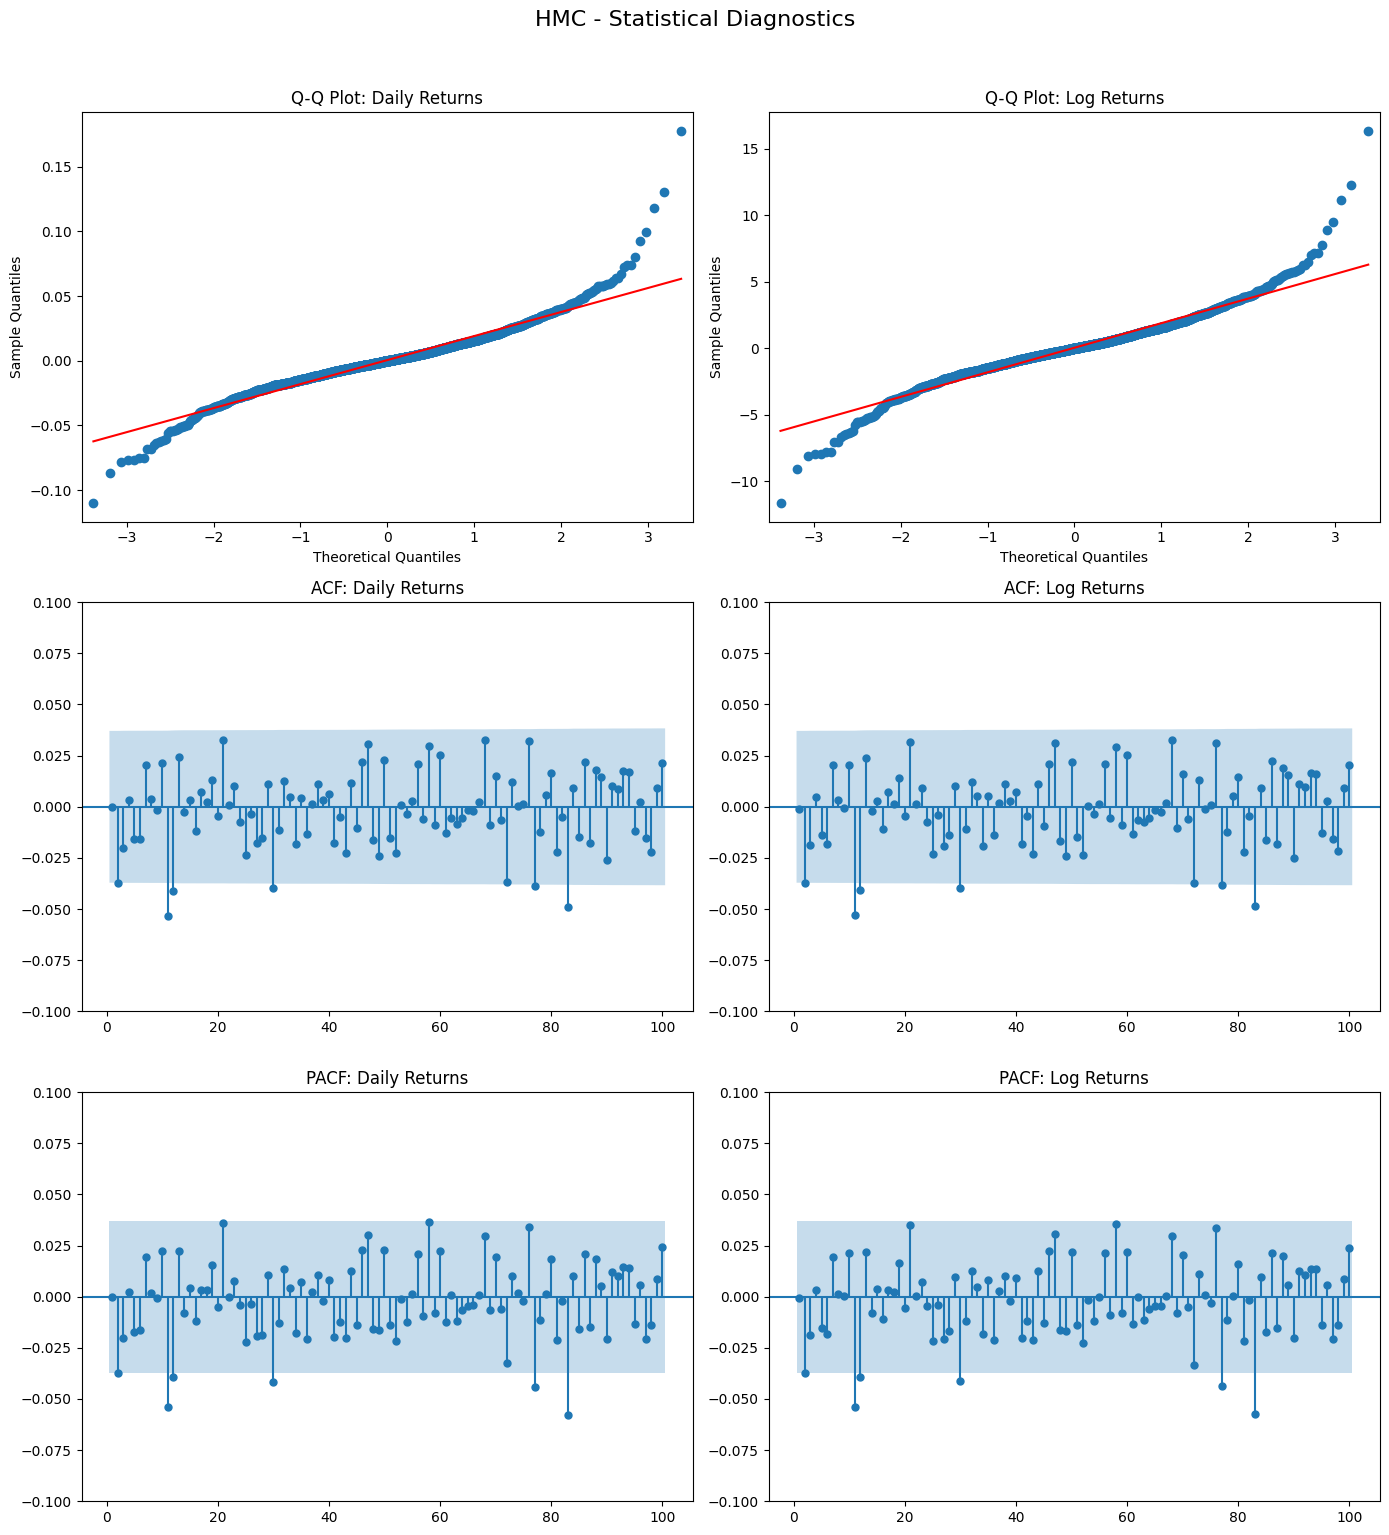

Generating diagnostics for MAH...


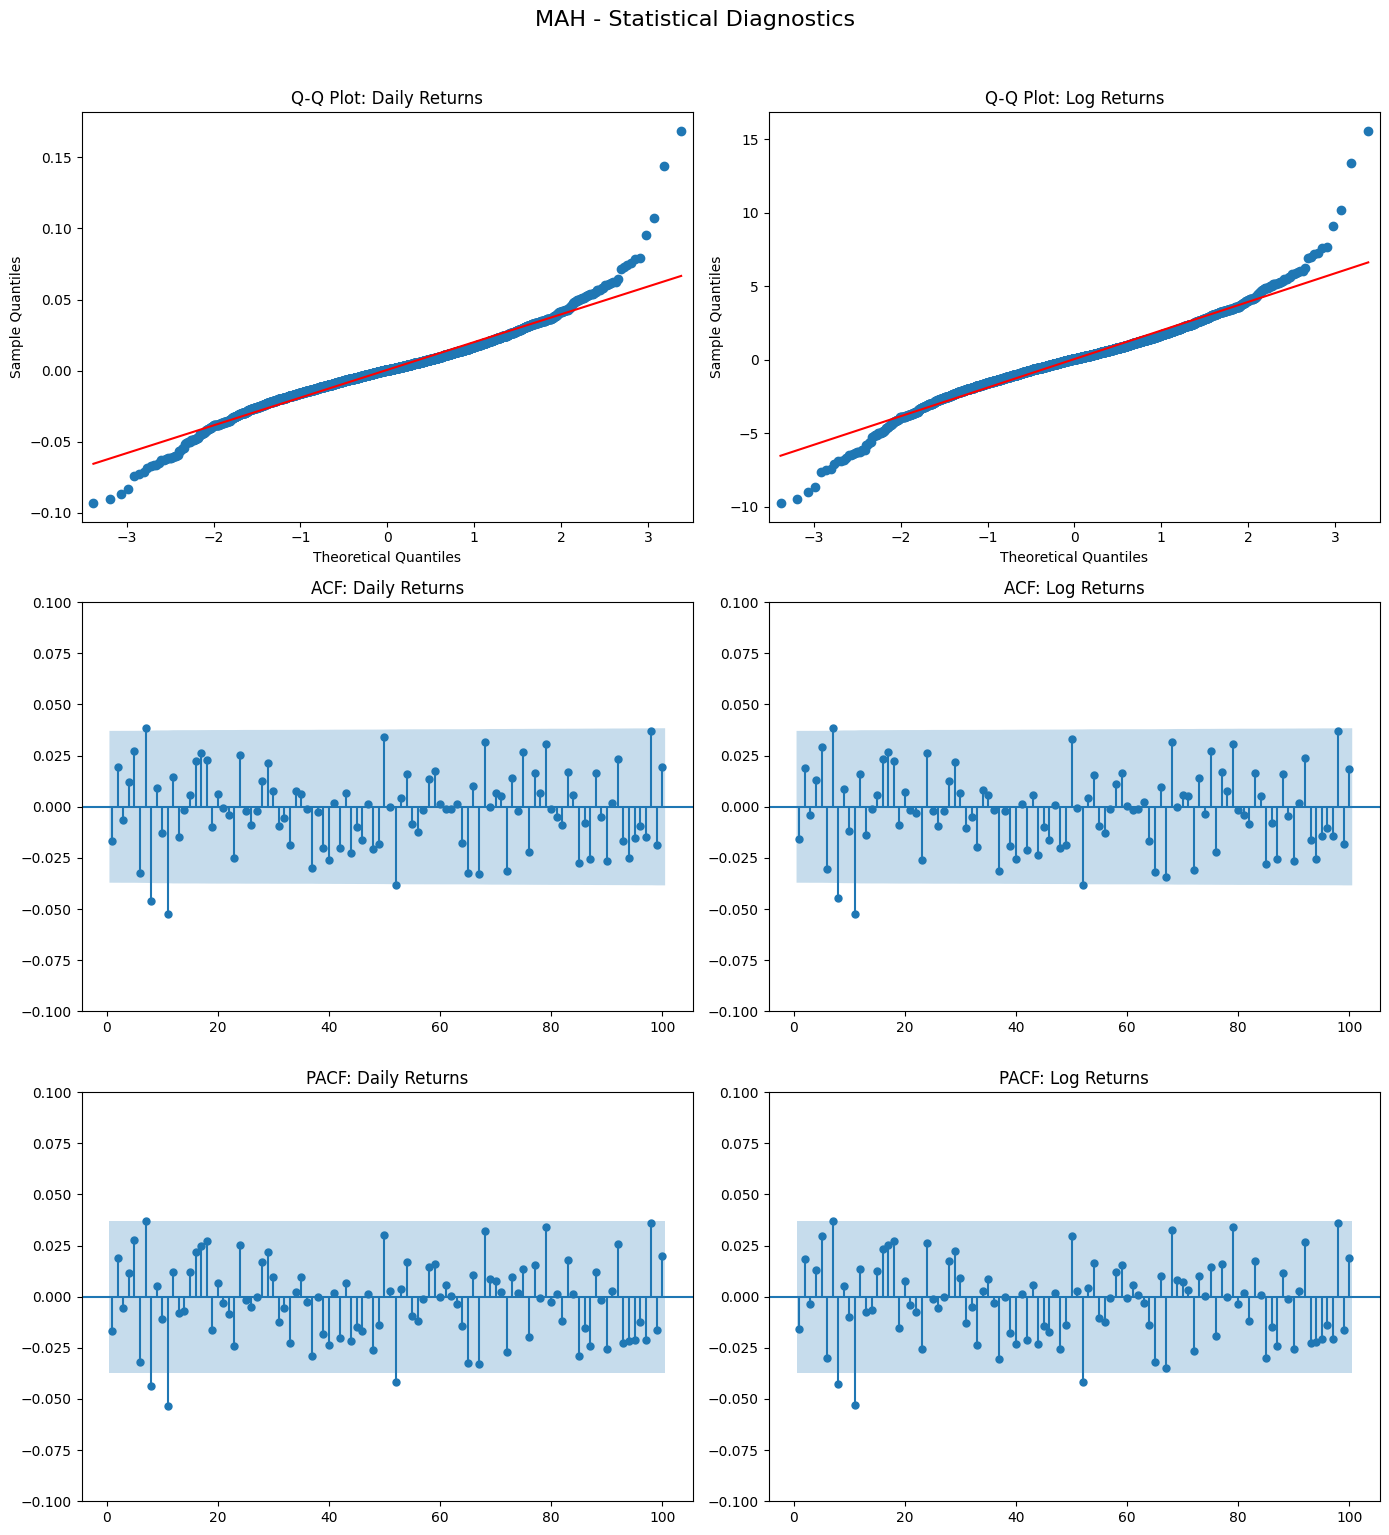


--- Descriptive Statistics (Step 3 Output) ---


,Daily Returns Mean,Daily Returns Std,Daily Returns Skew,Daily Returns Kurtosis,Log Returns Mean,Log Returns Std,Log Returns Skew,Log Returns Kurtosis
SBI,0.000445,0.022140,0.849226,11.490285,0.020202,2.198372,0.482944,8.403883
HDB,0.000912,0.015019,0.046215,6.885545,0.079919,1.501541,-0.158465,7.317037
KMB,0.000949,0.018330,0.112811,4.350488,0.078104,1.831400,-0.063137,4.495432
BAJ,0.000768,0.016603,0.075549,5.501496,0.062999,1.659779,-0.115874,5.893541
MSZ,0.000721,0.018660,0.083913,7.671699,0.054640,1.866343,-0.196809,8.425724
ICB,0.000776,0.021785,0.241594,4.798828,0.053948,2.174684,0.013701,5.236954
TAM,0.000600,0.026773,0.332288,4.872089,0.024319,2.670317,0.063522,4.741308
AXB,0.000763,0.023150,-0.174327,12.316681,0.049366,2.327656,-0.761030,17.809509
HMC,0.000491,0.018576,0.549384,6.588497,0.031901,1.849796,0.331748,5.701444
MAH,0.000597,0.019516,0.357836,4.899350,0.040742,1.946069,0.170347,4.250067


In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm


def analyze_returns(ticker, df):
    """
    Plots Q-Q, ACF, and PACF diagnostics and computes descriptive stats.
    """
    # Extract series
    series_map = {
        'Daily Returns': df['Daily Return'].dropna(),
        'Log Returns': df['Log Return'].dropna()
    }

    # Initialize layout
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    fig.suptitle(f'{ticker} - Statistical Diagnostics', fontsize=16, y=1.02)

    stats = {}

    # Loop through columns to generate plots (Reduces code duplication)
    for col_idx, (label, data) in enumerate(series_map.items()):

        # 1. Q-Q Plot (Check Normality)
        sm.qqplot(data, line='s', ax=axes[0, col_idx])
        axes[0, col_idx].set_title(f'Q-Q Plot: {label}')

        # 2. ACF Plot (Autocorrelation)
        # zero=False removes the Lag 0 spike (always 1.0) automatically
        sm.graphics.tsa.plot_acf(data, lags=100, zero=False, ax=axes[1, col_idx])
        axes[1, col_idx].set_title(f'ACF: {label}')
        axes[1, col_idx].set_ylim(-0.1, 0.1)  # Zoom in to see significance

        # 3. PACF Plot (Partial Autocorrelation)
        sm.graphics.tsa.plot_pacf(data, lags=100, zero=False, method='ywm', ax=axes[2, col_idx])
        axes[2, col_idx].set_title(f'PACF: {label}')
        axes[2, col_idx].set_ylim(-0.1, 0.1)

        # 4. Compute Stats for table
        stats[f'{label} Mean'] = data.mean()
        stats[f'{label} Std'] = data.std()
        stats[f'{label} Skew'] = data.skew()
        stats[f'{label} Kurtosis'] = data.kurtosis()

    plt.tight_layout()
    plt.show()
    return stats

# --- Main Execution Step 3 ---

print("Starting Step 3: Statistical Plots & Measures...\n")
summary_stats = {}

for ticker, df in portfolio_data.items():
    print(f"Generating diagnostics for {ticker}...")
    summary_stats[ticker] = analyze_returns(ticker, df)

# Display Statistical Summary Table
print("\n--- Descriptive Statistics (Step 3 Output) ---")
stats_df = pd.DataFrame(summary_stats).T
display(stats_df)

In [ ]:

!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 12.9 MB/s eta 0:00:00


--- Step 4: Fitting GARCH(1,1) Normal ---



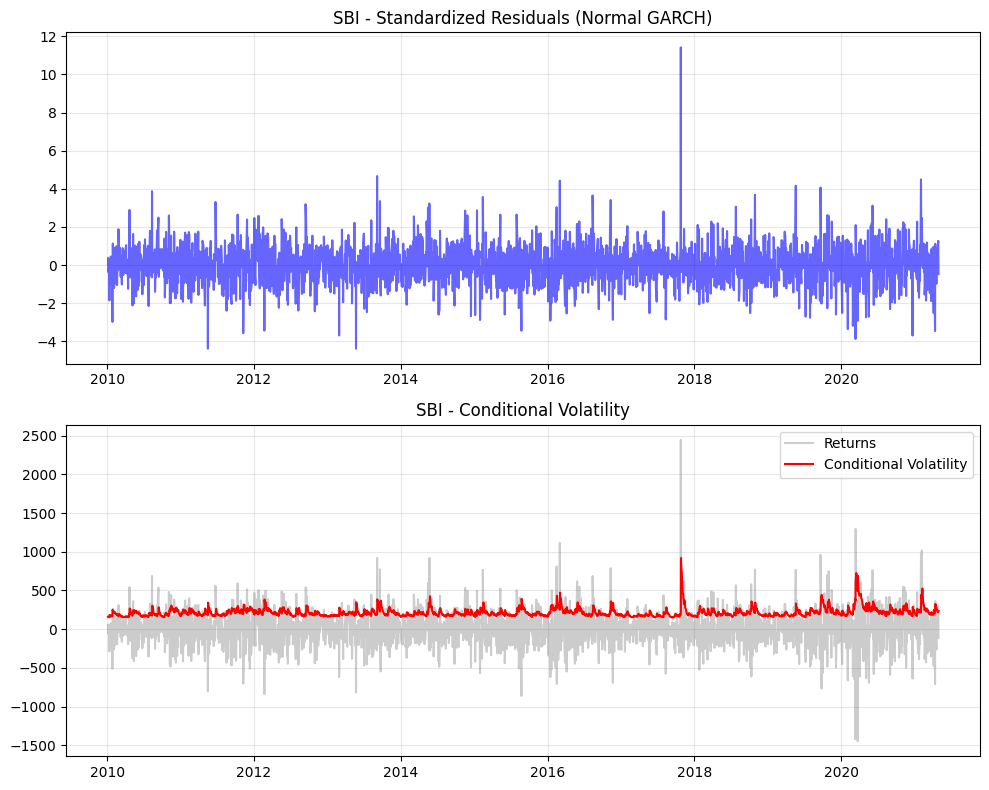

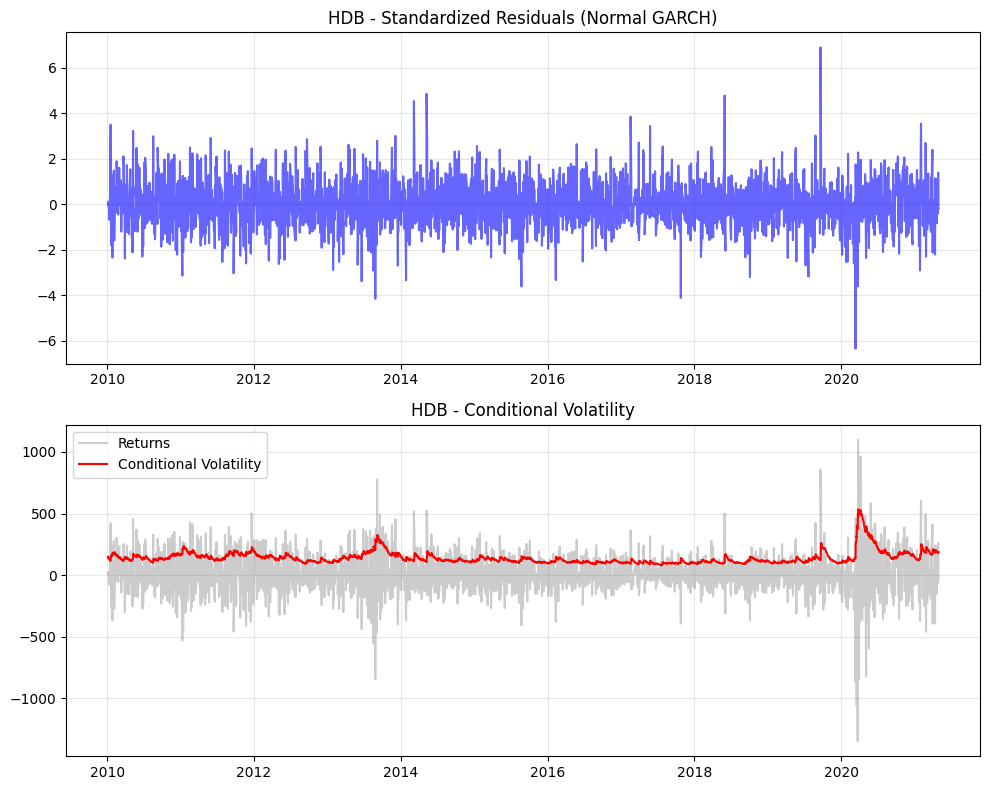

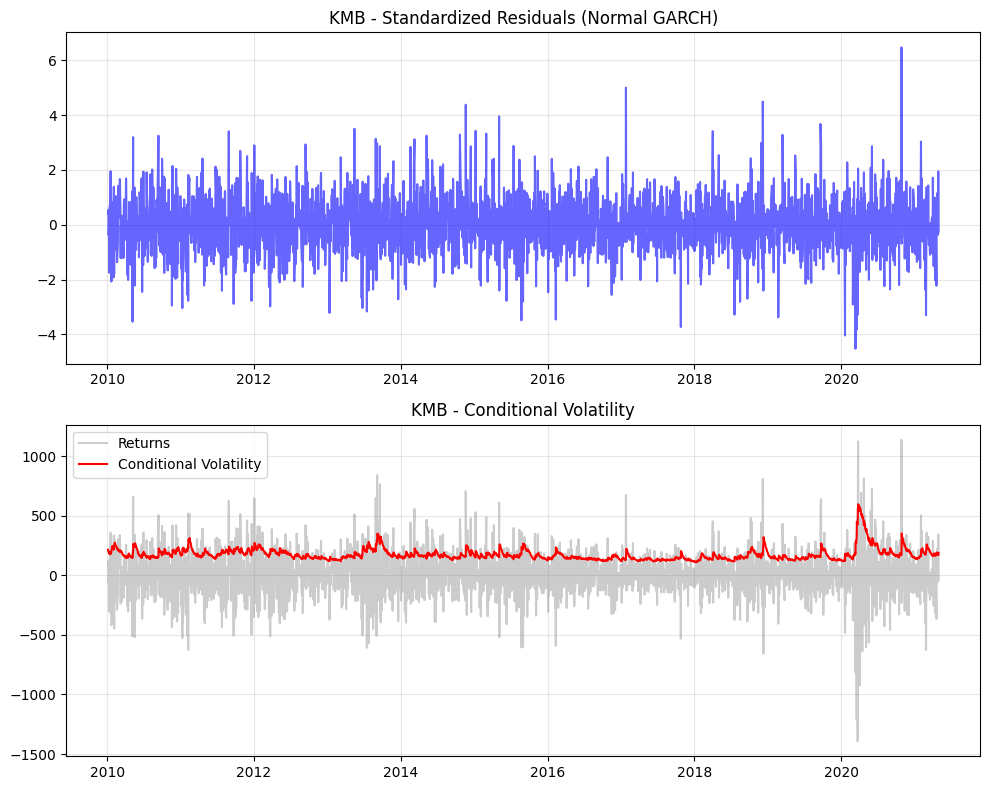

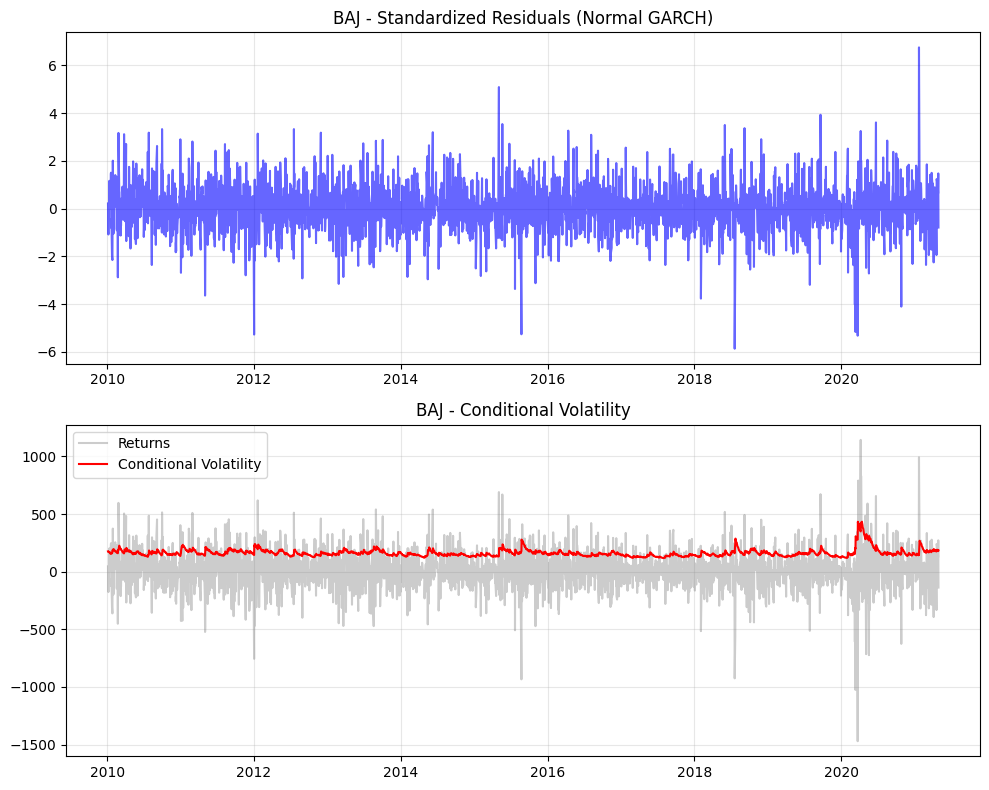

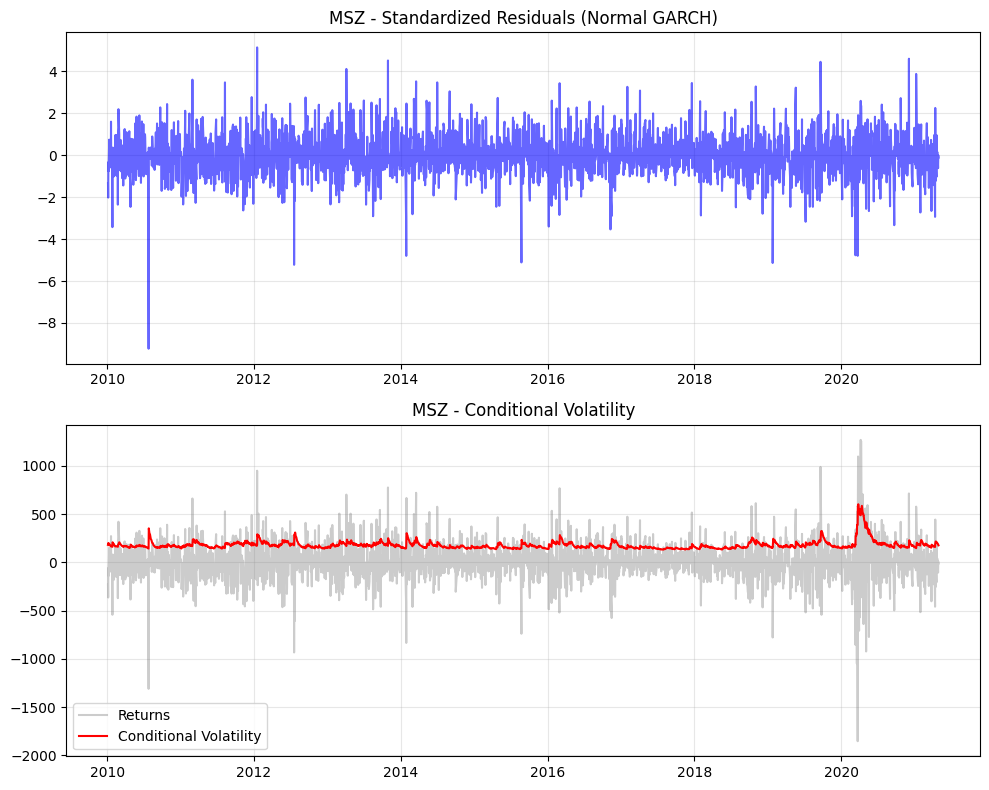

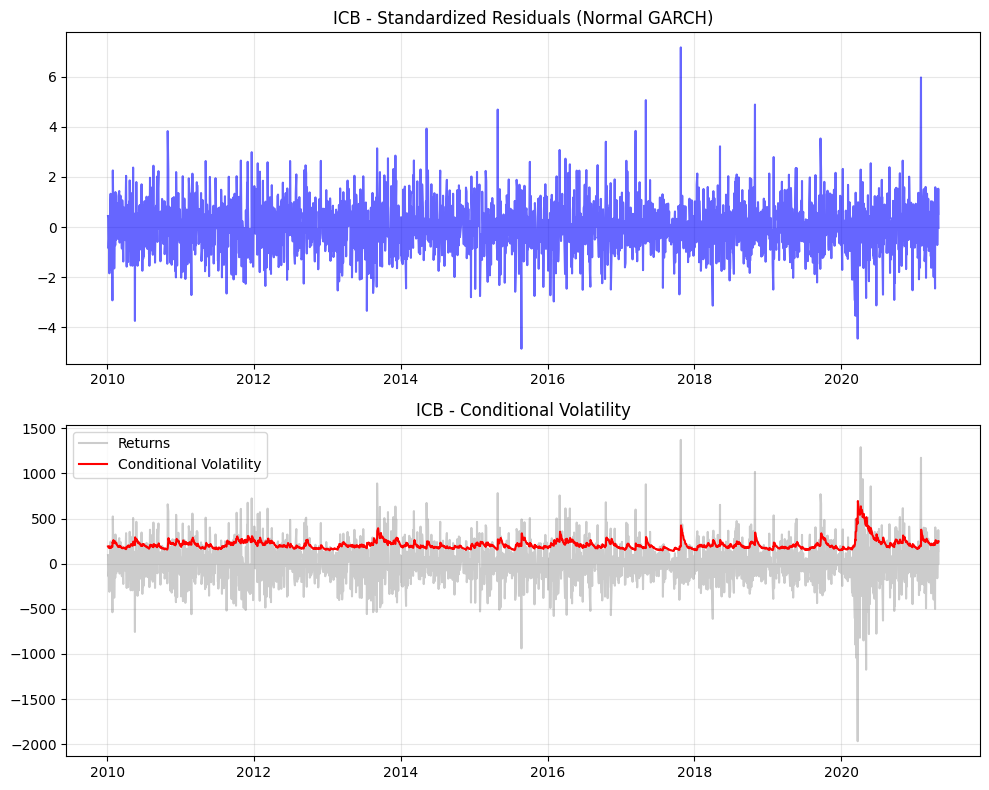

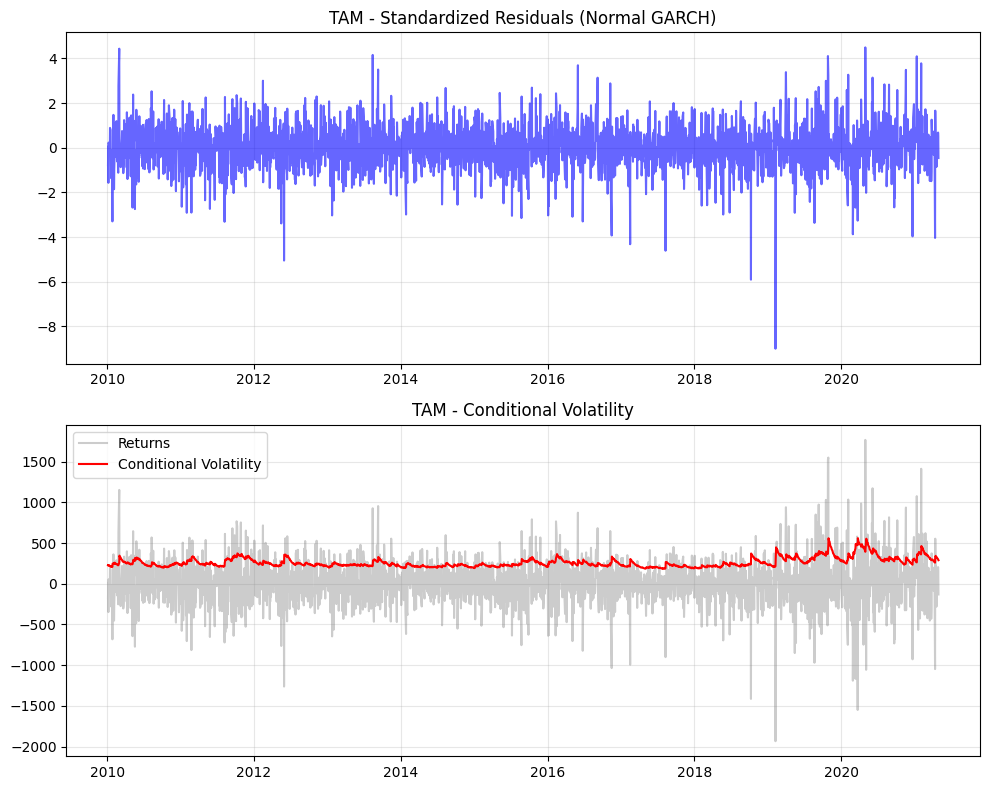

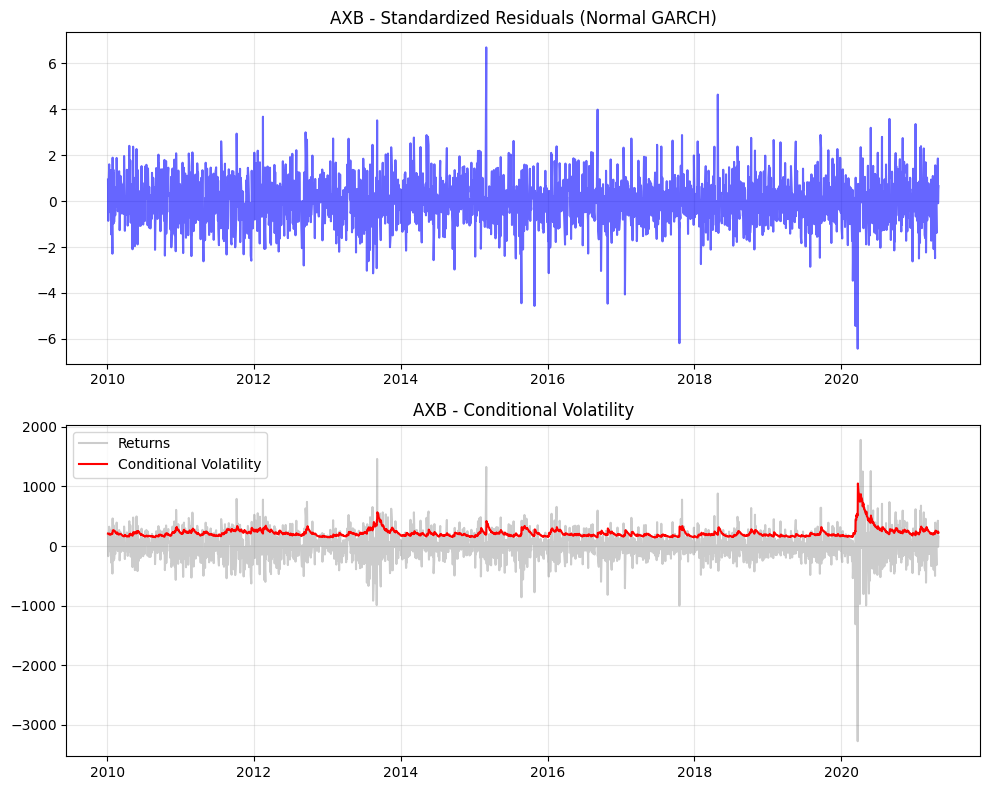

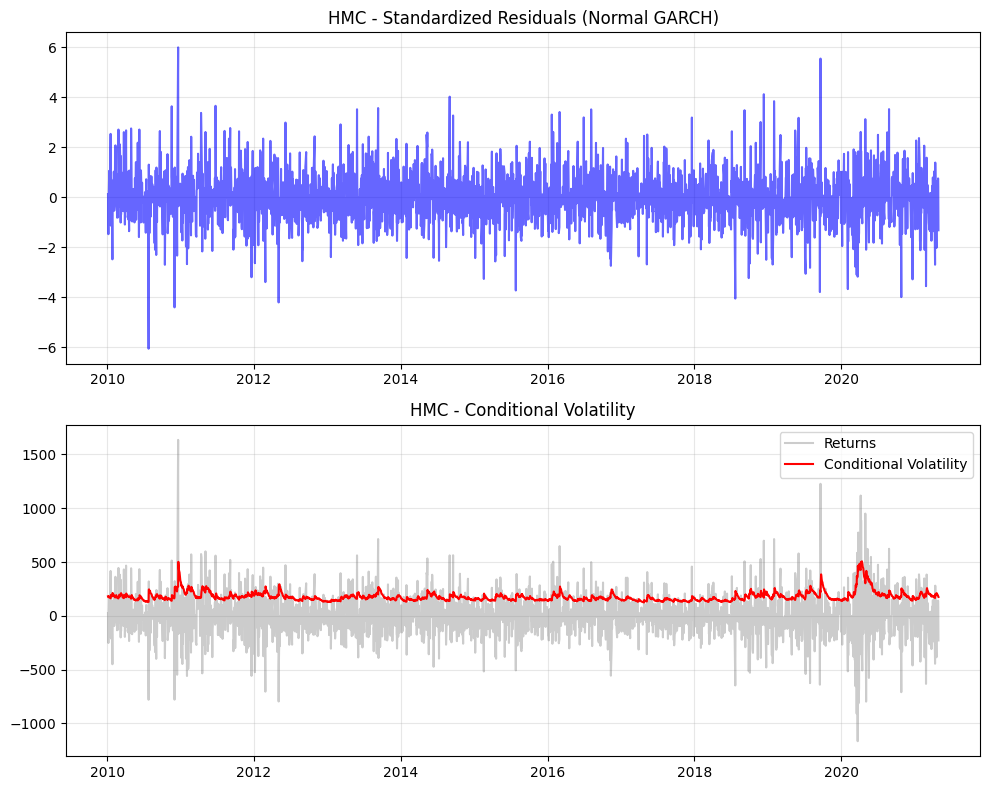

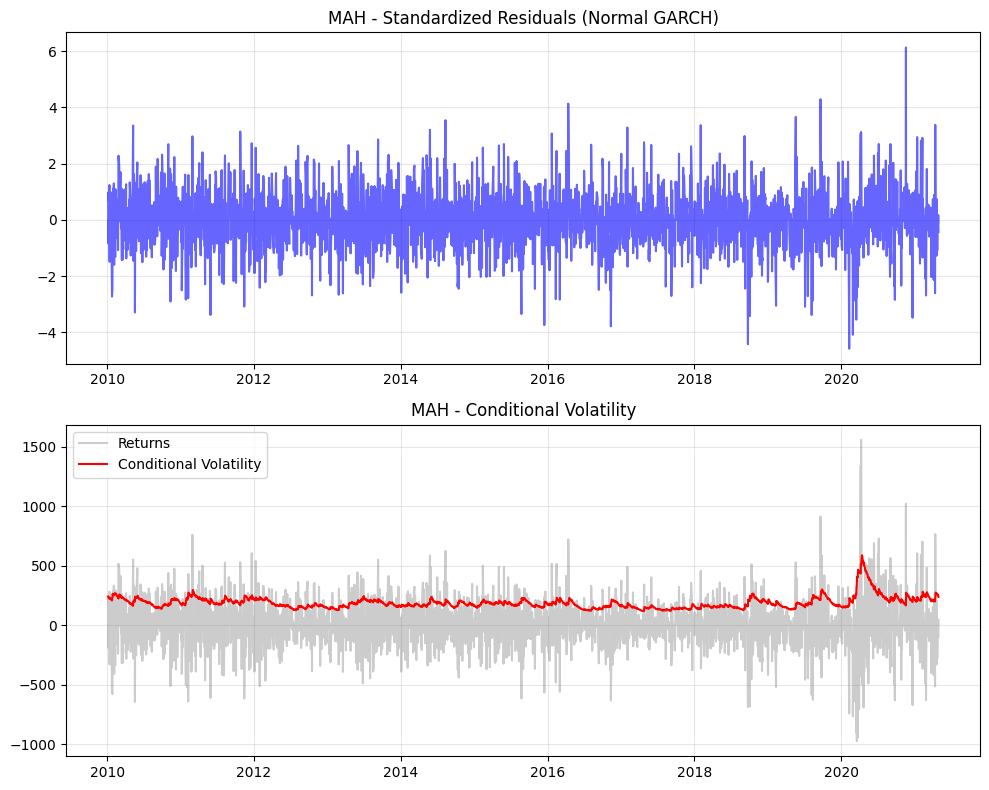


--- Step 4 Results (Normal Distribution) ---


,AIC (Normal),BIC (Normal),Omega,Alpha,Beta
Ticker,,,,,
SBI,37789.188663,37812.925284,4831.116481,0.134952,0.772873
HDB,35252.856369,35276.592990,363.798246,0.063411,0.919290
KMB,36588.422198,36612.158819,1099.207909,0.074892,0.891013
BAJ,36251.471206,36275.207827,1089.317151,0.053169,0.907047
MSZ,36749.248417,36772.985038,1743.663881,0.059615,0.886655
ICB,37640.606650,37664.343271,2229.864992,0.078453,0.873590
TAM,38860.594430,38884.331051,1425.609919,0.041304,0.938800
AXB,37769.635168,37793.371789,1827.589618,0.080479,0.883269
HMC,36736.299598,36760.036219,1496.011003,0.069502,0.885363


In [ ]:
from arch import arch_model
import matplotlib.pyplot as plt
import pandas as pd

# Storage for results
garch_normal_results = {}
summary_data_normal = []

print("--- Step 4: Fitting GARCH(1,1) Normal ---\n")

for ticker, df in portfolio_data.items():
    # This matches the scale used in Step 5, making AIC/BIC comparable.
    if 'Log Return' not in df.columns:
        continue

    scaled_returns = df['Log Return'].dropna() * 100

    if len(scaled_returns) < 50:
        print(f"Skipping {ticker}: Insufficient data.")
        continue

    try:
        # 2. Fit GARCH(1,1) with Normal Distribution
        # Using the simplified 'arch_model' wrapper which bundles Mean & Volatility
        model = arch_model(scaled_returns, mean='Constant', vol='GARCH', p=1, q=1, dist='Normal')
        res = model.fit(disp='off')

        garch_normal_results[ticker] = {
            'params': res.params,
            'pvalues': res.pvalues,
            'aic': res.aic,
            'bic': res.bic,
            'resid': res.std_resid,
            'volatility': res.conditional_volatility,
            'summary': res.summary()
        }

        # 4. Add to Summary Table
        summary_data_normal.append({
            'Ticker': ticker,
            'AIC (Normal)': res.aic,
            'BIC (Normal)': res.bic,
            'Omega': res.params.get('omega'),
            'Alpha': res.params.get('alpha[1]'),
            'Beta': res.params.get('beta[1]')
        })

        # 5. Visualization (Refactored into Subplots)
        fig, axes = plt.subplots(2, 1, figsize=(10, 8))

        # Plot Standardized Residuals
        axes[0].plot(res.std_resid, color='blue', alpha=0.6)
        axes[0].set_title(f'{ticker} - Standardized Residuals (Normal GARCH)')
        axes[0].grid(True, alpha=0.3)

        # Plot Conditional Volatility
        axes[1].plot(scaled_returns, color='gray', alpha=0.4, label='Returns')
        axes[1].plot(res.conditional_volatility, color='red', linewidth=1.5, label='Conditional Volatility')
        axes[1].set_title(f'{ticker} - Conditional Volatility')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error fitting GARCH for {ticker}: {e}")

# 6. Display Comparison Data
print("\n--- Step 4 Results (Normal Distribution) ---")
step4_df = pd.DataFrame(summary_data_normal).set_index('Ticker')
display(step4_df)


In [ ]:
from arch import arch_model

# Storage for results
skewt_results = {}
summary_data = []

print("--- Step 5: GARCH(1,1) Skewed-t with P-Values ---\n")

for ticker, df in portfolio_data.items():
    # 1. Scale Log Returns (Critical for correct AIC & Convergence)
    if 'Log Return' not in df.columns:
        continue
    scaled_returns = df['Log Return'].dropna() * 100

    if len(scaled_returns) < 50:
        continue

    try:
        # 2. Fit Skewed-t GARCH
        model = arch_model(scaled_returns, mean='Constant', vol='GARCH', p=1, q=1, dist='skewt')
        res = model.fit(disp='off')

        skewt_results[ticker] = res
        params = res.params
        pvalues = res.pvalues

        # 3. Robust Extraction (Handling 'nu' vs 'eta')
        nu_val = params.get('nu', params.get('eta', np.nan))
        nu_p = pvalues.get('nu', pvalues.get('eta', np.nan))

        row = {
            'Ticker': ticker,
            'AIC': res.aic,
            # Mean & Variance
            'mu': params.get('mu'),          'mu (P-val)': pvalues.get('mu'),
            'omega': params.get('omega'),    'omega (P-val)': pvalues.get('omega'),
            'alpha': params.get('alpha[1]'), 'alpha (P-val)': pvalues.get('alpha[1]'),
            'beta': params.get('beta[1]'),   'beta (P-val)': pvalues.get('beta[1]'),
            # Shape Parameters
            'nu/eta': nu_val,                'nu/eta (P-val)': nu_p,
            'lambda': params.get('lambda'),  'lambda (P-val)': pvalues.get('lambda')
        }
        summary_data.append(row)

    except Exception as e:
        print(f"Error fitting {ticker}: {e}")

# 5. Display Summary
step5_df = pd.DataFrame(summary_data)
if not step5_df.empty:
    step5_df.set_index('Ticker', inplace=True)

    print("\n--- Model Summary (Skewed-t Distribution) ---")
    # Rounding for cleaner view
    display(step5_df.round(4))

    print("\n--- Significance Check ---")
    print("1. P-val < 0.05: The parameter is statistically significant.")
    print("2. nu/eta: Measures 'Fat Tails'. Low values (e.g., 4-8) = High likelihood of extreme crashes.")
    print("3. lambda: Measures 'Skewness'. Negative = Crashes are more common than rallies.")
else:
    print("No models converged.")

--- Step 5: GARCH(1,1) Skewed-t with P-Values ---


--- Model Summary (Skewed-t Distribution) ---


,AIC,mu,mu (P-val),omega,omega (P-val),alpha,alpha (P-val),beta,beta (P-val),nu/eta,nu/eta (P-val),lambda,lambda (P-val)
Ticker,,,,,,,,,,,,,
SBI,37541.5556,1.6408,0.6599,3007.8298,0.0001,0.0865,0.0000,0.8509,0.0,5.6603,0.0,-0.0029,0.9097
HDB,35109.6778,9.7687,0.0000,265.6981,0.0297,0.0594,0.0001,0.9291,0.0,6.5639,0.0,0.0834,0.0015
KMB,36442.7498,8.9244,0.0022,670.5585,0.0325,0.0655,0.0001,0.9150,0.0,6.0739,0.0,0.0119,0.6512
BAJ,36008.5375,6.9549,0.0194,989.2777,0.2594,0.0459,0.0587,0.9190,0.0,4.7588,0.0,0.0620,0.0136
MSZ,36448.5564,8.6802,0.0054,1041.8991,0.0491,0.0579,0.0005,0.9131,0.0,4.5581,0.0,0.0738,0.0016
ICB,37478.8984,6.7963,0.0602,1528.3104,0.0001,0.0651,0.0000,0.9023,0.0,6.2976,0.0,0.0677,0.0093
TAM,38610.1685,4.6470,0.3105,2563.7403,0.3600,0.0566,0.1320,0.9078,0.0,5.0266,0.0,0.0486,0.0644
AXB,37591.5309,8.6507,0.0173,1369.4737,0.0010,0.0731,0.0000,0.9005,0.0,5.8704,0.0,0.0515,0.0353
HMC,36515.3322,2.5699,0.4060,1080.1591,0.1757,0.0621,0.0144,0.9076,0.0,4.8937,0.0,0.0530,0.0295



--- Significance Check ---
1. P-val < 0.05: The parameter is statistically significant.
2. nu/eta: Measures 'Fat Tails'. Low values (e.g., 4-8) = High likelihood of extreme crashes.
3. lambda: Measures 'Skewness'. Negative = Crashes are more common than rallies.


In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 9.6 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm

# Storage for optimal (p, q) orders
best_arma_orders = {}

print("--- Step 6: Identifying Best-Fit ARMA Models (Minimizing BIC) ---\n")

for ticker, df in portfolio_data.items():
    # 1. Scale Log Returns
    if 'Log Return' not in df.columns:
        continue

    scaled_log_returns = df['Log Return'].dropna() * 100

    # Need sufficient data for ARIMA
    if len(scaled_log_returns) < 30:
        print(f"Skipping {ticker}: Insufficient data.")
        continue

    try:
        # 2. Run Auto-ARIMA
        # d=0 (Returns are stationary), ic='bic'
        model = pm.auto_arima(scaled_log_returns,
                              start_p=0, start_q=0,
                              max_p=3, max_q=3,
                              d=0,
                              seasonal=False,
                              ic='bic',
                              trace=False,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

        # 3. Extract and Store (p, q)
        best_p, _, best_q = model.order
        best_arma_orders[ticker] = (best_p, best_q)

        print(f"Best Model for {ticker}: ARMA({best_p}, {best_q}) | BIC: {model.bic():.4f}")

    except Exception as e:
        print(f"Error fitting ARMA for {ticker}: {e}")
        # Fallback to Constant Mean if ARMA fails
        best_arma_orders[ticker] = (0, 0)

print("\nStep 6 Complete. Optimal orders stored in 'best_arma_orders'.")
print(best_arma_orders)

--- Step 6: Identifying Best-Fit ARMA Models (Minimizing BIC) ---

Best Model for SBI: ARMA(1, 0) | BIC: 38032.3980
Best Model for HDB: ARMA(2, 0) | BIC: 35909.0288
Best Model for KMB: ARMA(0, 2) | BIC: 37030.5778
Best Model for BAJ: ARMA(0, 0) | BIC: 36469.7554
Best Model for MSZ: ARMA(0, 0) | BIC: 37124.5047
Best Model for ICB: ARMA(0, 0) | BIC: 37971.7903
Best Model for TAM: ARMA(0, 1) | BIC: 39119.4891
Best Model for AXB: ARMA(0, 1) | BIC: 38354.2518
Best Model for HMC: ARMA(0, 0) | BIC: 37067.6895
Best Model for MAH: ARMA(0, 0) | BIC: 37351.2905

Step 6 Complete. Optimal orders stored in 'best_arma_orders'.
{'SBI': (1, 0), 'HDB': (2, 0), 'KMB': (0, 2), 'BAJ': (0, 0), 'MSZ': (0, 0), 'ICB': (0, 0), 'TAM': (0, 1), 'AXB': (0, 1), 'HMC': (0, 0), 'MAH': (0, 0)}


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

# Storage for Step 7 results
arma_garch_results = {}

print("--- Step 7: Fitting ARMA Residuals into Zero-Mean GARCH(1,1) ---\n")

for ticker, df in portfolio_data.items():
    if 'Log Return' not in df.columns:
        continue

    # Prepare data: Scale log returns and force frequency for stability
    returns = df['Log Return'].dropna() * 100
    if not returns.index.freq:
        returns = returns.asfreq('B').fillna(method='ffill')

    # Retrieve optimal ARMA order from Step 6 (default to 0,0 if missing)
    p, q = best_arma_orders.get(ticker, (0, 0))

    try:
        # 1. Fit ARMA(p,q) to remove linear trends
        arma_fit = ARIMA(returns, order=(p, 0, q)).fit()
        arma_residuals = arma_fit.resid

        # 2. Fit Zero-Mean GARCH(1,1) to the ARMA residuals
        garch = arch_model(arma_residuals, mean='Zero', vol='GARCH', p=1, q=1, dist='Normal')
        res = garch.fit(disp='off')

        # 3. Print Parameters & Significance (P-values)
        print(f"Ticker: {ticker} | ARMA({p},{q}) -> GARCH(1,1)")
        print(f"  1.Omega: {res.params['omega']:.4f} (p={res.pvalues['omega']:.4f})")
        print(f"  2.Alpha: {res.params['alpha[1]']:.4f} (p={res.pvalues['alpha[1]']:.4f})")
        print(f"  3.Beta:  {res.params['beta[1]']:.4f}  (p={res.pvalues['beta[1]']:.4f})")
        print(f"  4.AIC:   {res.aic:.2f}")
        print(f"  5.BIC:   {res.bic:.2f}\n")

        # Store results
        arma_garch_results[ticker] = {
            'arma_order': (p, q),
            'garch_res': res,
            'bic': res.bic
        }

    except Exception as e:
        print(f"Error for {ticker}: {e}")

print("Step 7 Complete.")

--- Step 7: Fitting ARMA Residuals into Zero-Mean GARCH(1,1) ---

Ticker: SBI | ARMA(1,0) -> GARCH(1,1)
  1.Omega: 5587.5334 (p=0.0408)
  2.Alpha: 0.1509 (p=0.0155)
  3.Beta:  0.7398  (p=0.0000)
  4.AIC:   39911.81
  5.BIC:   39929.78

Ticker: HDB | ARMA(2,0) -> GARCH(1,1)
  1.Omega: 334.3687 (p=0.0317)
  2.Alpha: 0.0616 (p=0.0003)
  3.Beta:  0.9221  (p=0.0000)
  4.AIC:   37250.28
  5.BIC:   37268.26

Ticker: KMB | ARMA(0,2) -> GARCH(1,1)
  1.Omega: 1314.0466 (p=0.0770)
  2.Alpha: 0.0865 (p=0.0011)
  3.Beta:  0.8726  (p=0.0000)
  4.AIC:   38679.53
  5.BIC:   38697.50

Ticker: BAJ | ARMA(0,0) -> GARCH(1,1)
  1.Omega: 1535.1796 (p=0.2659)
  2.Alpha: 0.0745 (p=0.0655)
  3.Beta:  0.8705  (p=0.0000)
  4.AIC:   38353.67
  5.BIC:   38371.64

Ticker: MSZ | ARMA(0,0) -> GARCH(1,1)
  1.Omega: 3530.7077 (p=0.5444)
  2.Alpha: 0.1003 (p=0.3871)
  3.Beta:  0.7917  (p=0.0061)
  4.AIC:   38866.82
  5.BIC:   38884.79

Ticker: ICB | ARMA(0,0) -> GARCH(1,1)
  1.Omega: 2177.5140 (p=0.0009)
  2.Alpha: 0.08

In [ ]:
import pandas as pd
from arch import arch_model

# Storage for Step 8 results
asymmetric_analysis = {}

print("--- Step 8: Fitting GJR-GARCH vs. EGARCH (Asymmetric Models) ---\n")

for ticker, df in portfolio_data.items():
    if 'Log Return' not in df.columns:
        continue

    # 1. Prepare Data: Scale returns and ensure frequency for stability
    # Multiplied by 100 to scale helps optimization convergence
    returns = df['Log Return'].dropna() * 100
    if not returns.index.freq:
        returns = returns.asfreq('B').fillna(method='ffill')

    try:
        print(f"Analyzing {ticker}...")

        # --- Model 1: GJR-GARCH (1,1,1) ---
        # vol='GARCH' with o=1 creates GJR-GARCH
        gjr_model = arch_model(returns, p=1, q=1, o=1, vol='GARCH', dist='t')
        gjr_res = gjr_model.fit(disp='off')

        # --- Model 2: EGARCH (1,1,1) ---
        # vol='EGARCH' with o=1
        egarch_model = arch_model(returns, p=1, q=1, o=1, vol='EGARCH', dist='t')
        egarch_res = egarch_model.fit(disp='off')

        # --- Evaluation & Extraction ---
        def get_stats(res, name):
            param = res.params.get(name, float('nan'))
            pval = res.pvalues.get(name, float('nan'))
            return param, pval

        # Extract stats for GJR
        gjr_omega, gjr_omega_p = get_stats(gjr_res, 'omega')
        gjr_alpha, gjr_alpha_p = get_stats(gjr_res, 'alpha[1]')
        gjr_gamma, gjr_gamma_p = get_stats(gjr_res, 'gamma[1]')
        gjr_beta, gjr_beta_p   = get_stats(gjr_res, 'beta[1]')

        # Extract stats for EGARCH
        eg_omega, eg_omega_p = get_stats(egarch_res, 'omega')
        eg_alpha, eg_alpha_p = get_stats(egarch_res, 'alpha[1]')
        eg_gamma, eg_gamma_p = get_stats(egarch_res, 'gamma[1]')
        eg_beta, eg_beta_p   = get_stats(egarch_res, 'beta[1]')

        # --- Comparison ---
        better_model = "EGARCH" if egarch_res.bic < gjr_res.bic else "GJR-GARCH"

        # Print formatted results
        print(f"  [GJR-GARCH] BIC: {gjr_res.bic:.2f}")
        print(f"    omega: {gjr_omega:.3f} (p={gjr_omega_p:.3f}), alpha: {gjr_alpha:.3f} (p={gjr_alpha_p:.3f})")
        print(f"    gamma: {gjr_gamma:.3f} (p={gjr_gamma_p:.3f}), beta: {gjr_beta:.3f} (p={gjr_beta_p:.3f})")

        print(f"  [EGARCH]    BIC: {egarch_res.bic:.2f}")
        print(f"    omega: {eg_omega:.3f} (p={eg_omega_p:.3f}), alpha: {eg_alpha:.3f} (p={eg_alpha_p:.3f})")
        print(f"    gamma: {eg_gamma:.3f} (p={eg_gamma_p:.3f}), beta: {eg_beta:.3f} (p={eg_beta_p:.3f})")

        print(f"  1.SUPERIOR FIT: {better_model}\n")

        # Store results
        asymmetric_analysis[ticker] = {
            'Best_Model': better_model,
            'GJR_BIC': gjr_res.bic,
            'EGARCH_BIC': egarch_res.bic,
            'Model_Object': egarch_res if better_model == 'EGARCH' else gjr_res
        }

    except Exception as e:
        print(f"Error for {ticker}: {e}")

print("Step 8 Complete.")

--- Step 8: Fitting GJR-GARCH vs. EGARCH (Asymmetric Models) ---

Analyzing SBI...
  [GJR-GARCH] BIC: 39733.51
    omega: 3559.834 (p=0.001), alpha: 0.092 (p=0.001)
    gamma: 0.037 (p=0.131), beta: 0.816 (p=0.000)
  [EGARCH]    BIC: 39739.27
    omega: 1.575 (p=0.370), alpha: 0.287 (p=0.016)
    gamma: -0.025 (p=0.219), beta: 0.854 (p=0.000)
  1.SUPERIOR FIT: GJR-GARCH

Analyzing HDB...
  [GJR-GARCH] BIC: 37155.66
    omega: 241.318 (p=0.034), alpha: 0.027 (p=0.049)
    gamma: 0.062 (p=0.000), beta: 0.933 (p=0.000)
  [EGARCH]    BIC: 37199.40
    omega: 0.809 (p=0.105), alpha: 0.284 (p=0.001)
    gamma: -0.065 (p=0.001), beta: 0.919 (p=0.000)
  1.SUPERIOR FIT: GJR-GARCH

Analyzing KMB...
Error for KMB: Singular matrix
Analyzing BAJ...
  [GJR-GARCH] BIC: 38148.22
    omega: 2797.036 (p=0.666), alpha: 0.061 (p=0.641)
    gamma: 0.112 (p=0.333), beta: 0.793 (p=0.047)
  [EGARCH]    BIC: 38147.25
    omega: 1.732 (p=0.290), alpha: 0.310 (p=0.036)
    gamma: -0.072 (p=0.002), beta: 0.832 (p